# &#x1F4D1; &nbsp; P5: Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
## Code Tools and Links

In [1]:
%%html
<style>
@import url('https://fonts.googleapis.com/css?family=Orbitron|Roboto');
body {background-color: lavender;}
a {color: #8A2BE2; font-family: Roboto;}
h1, h2 {color: #9370DB; font-family: Orbitron; text-shadow: 4px 4px 4px #aaa;}
h3, h4 {color: #663399; font-family: Roboto; text-shadow: 4px 4px 4px #aaa;}
span {text-shadow: 4px 4px 4px #ccc;}
div.output_prompt, div.output_area pre {color: slategray;}
div.input_prompt, div.output_subarea {color: #8A2BE2;}      
div.output_stderr pre {background-color: lavender;}  
div.output_stderr {background-color: slategrey;}        
</style>
<script>
code_show = true; 
function code_display() {
    if (code_show) {
        $('div.input').each(function(id) {
            if (id == 0 || $(this).html().indexOf('hide_code') > -1) {$(this).hide();}
        });
        $('div.output_prompt').css('opacity', 0);
    } else {
        $('div.input').each(function(id) {$(this).show();});
        $('div.output_prompt').css('opacity', 1);
    };
    code_show = !code_show;
} 
$(document).ready(code_display);
</script>
<form action="javascript: code_display()">
<input style="color: #8A2BE2; background: lavender; text-shadow: 4px 4px 4px #aaa;" \ 
type="submit" value="Click to display or hide code cells">
</form>

In [2]:
hide_code=''
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import math
import os

import hashlib
from urllib.request import urlretrieve
import zipfile
import gzip
import shutil

import numpy as np
from PIL import Image
from tqdm import tqdm

from copy import deepcopy
from unittest import mock

from distutils.version import LooseVersion
import warnings

import tensorflow as tf

from glob import glob
from matplotlib import pyplot
from matplotlib import cm

In [3]:
hide_code
# https://github.com/udacity/deep-learning/blob/master/face_generation/helper.py
def _read32(bytestream):
    """Read 32-bit integer from bytesteam
       :param bytestream: A bytestream
       :return: 32-bit integer"""
    dt = np.dtype(np.uint32).newbyteorder('>')
    return np.frombuffer(bytestream.read(4), dtype=dt)[0]

def _unzip(save_path, _, database_name, data_path):
    """Unzip wrapper with the same interface as _ungzip
       :param save_path: The path of the gzip files
       :param database_name: Name of database
       :param data_path: Path to extract to
       :param _: HACK - Used to have to same interface as _ungzip"""
    print('Extracting {}...'.format(database_name))
    with zipfile.ZipFile(save_path) as zf:
        zf.extractall(data_path)

def _ungzip(save_path, extract_path, database_name, _):
    """Unzip a gzip file and extract it to extract_path
       :param save_path: The path of the gzip files
       :param extract_path: The location to extract the data to
       :param database_name: Name of database
       :param _: HACK - Used to have to same interface as _unzip"""
    # Get data from save_path
    with open(save_path, 'rb') as f:
        with gzip.GzipFile(fileobj=f) as bytestream:
            magic = _read32(bytestream)
            if magic != 2051:
                raise ValueError('Invalid magic number {} in file: {}'.format(magic, f.name))
            num_images = _read32(bytestream)
            rows = _read32(bytestream)
            cols = _read32(bytestream)
            buf = bytestream.read(rows * cols * num_images)
            data = np.frombuffer(buf, dtype=np.uint8)
            data = data.reshape(num_images, rows, cols)

    # Save data to extract_path
    for image_i, image in enumerate(
            tqdm(data, unit='File', unit_scale=True, miniters=1, desc='Extracting {}'.format(database_name))):
        Image.fromarray(image, 'L').save(os.path.join(extract_path, 'image_{}.jpg'.format(image_i)))  

In [4]:
hide_code
# https://github.com/udacity/deep-learning/blob/master/face_generation/helper.py
def get_image(image_path, width, height, mode):
    """Read image from image_path
       :param image_path: Path of image
       :param width: Width of image
       :param height: Height of image
       :param mode: Mode of image
       :return: Image data"""
    image = Image.open(image_path)

    if image.size != (width, height):  # HACK - Check if image is from the CELEBA dataset
        # Remove most pixels that aren't part of a face
        face_width = face_height = 108
        j = (image.size[0] - face_width) // 2
        i = (image.size[1] - face_height) // 2
        image = image.crop([j, i, j + face_width, i + face_height])
        image = image.resize([width, height], Image.BILINEAR)

    return np.array(image.convert(mode))

def get_batch(image_files, width, height, mode):
    data_batch = np.array(
        [get_image(sample_file, width, height, mode) for sample_file in image_files]).astype(np.float32)

    # Make sure the images are in 4 dimensions
    if len(data_batch.shape) < 4:
        data_batch = data_batch.reshape(data_batch.shape + (1,))

    return data_batch

In [5]:
hide_code
# https://github.com/udacity/deep-learning/blob/master/face_generation/helper.py
def images_square_grid(images, mode):
    """Save images as a square grid
       :param images: Images to be used for the grid
       :param mode: The mode to use for images
       :return: Image of images in a square grid"""
    # Get maximum size for square grid of images
    save_size = math.floor(np.sqrt(images.shape[0]))

    # Scale to 0-255
    images = (((images - images.min()) * 255) / (images.max() - images.min())).astype(np.uint8)

    # Put images in a square arrangement
    images_in_square = np.reshape(
            images[:save_size*save_size],
            (save_size, save_size, images.shape[1], images.shape[2], images.shape[3]))
    if mode == 'L':
        images_in_square = np.squeeze(images_in_square, 4)

    # Combine images to grid image
    new_im = Image.new(mode, (images.shape[1] * save_size, images.shape[2] * save_size))
    for col_i, col_images in enumerate(images_in_square):
        for image_i, image in enumerate(col_images):
            im = Image.fromarray(image, mode)
            new_im.paste(im, (col_i * images.shape[1], image_i * images.shape[2]))

    return new_im

In [6]:
hide_code
# https://github.com/udacity/deep-learning/blob/master/face_generation/helper.py
def download_extract(database_name, data_path):
    """Download and extract database
       :param database_name: Database name"""
    DATASET_CELEBA_NAME = 'celeba'
    DATASET_MNIST_NAME = 'mnist'

    if database_name == DATASET_CELEBA_NAME:
        url = 'https://s3-us-west-1.amazonaws.com/udacity-dlnfd/datasets/celeba.zip'
        hash_code = '00d2c5bc6d35e252742224ab0c1e8fcb'
        extract_path = os.path.join(data_path, 'img_align_celeba')
        save_path = os.path.join(data_path, 'celeba.zip')
        extract_fn = _unzip
    elif database_name == DATASET_MNIST_NAME:
        url = 'http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz'
        hash_code = 'f68b3c2dcbeaaa9fbdd348bbdeb94873'
        extract_path = os.path.join(data_path, 'mnist')
        save_path = os.path.join(data_path, 'train-images-idx3-ubyte.gz')
        extract_fn = _ungzip

    if os.path.exists(extract_path):
        print('Found {} Data'.format(database_name))
        return

    if not os.path.exists(data_path):
        os.makedirs(data_path)

    if not os.path.exists(save_path):
        with DLProgress(unit='B', unit_scale=True, miniters=1, desc='Downloading {}'.format(database_name)) as pbar:
            urlretrieve(
                url,
                save_path,
                pbar.hook)

    assert hashlib.md5(open(save_path, 'rb').read()).hexdigest() == hash_code, \
        '{} file is corrupted.  Remove the file and try again.'.format(save_path)

    os.makedirs(extract_path)
    try:
        extract_fn(save_path, extract_path, database_name, data_path)
    except Exception as err:
        shutil.rmtree(extract_path)  # Remove extraction folder if there is an error
        raise err

    # Remove compressed data
    os.remove(save_path)

In [7]:
hide_code
# https://github.com/udacity/deep-learning/blob/master/face_generation/helper.py
class Dataset(object):
    def __init__(self, dataset_name, data_files):
        """Initalize the class
           :param dataset_name: Database name
           :param data_files: List of files in the database"""
        DATASET_CELEBA_NAME = 'celeba'
        DATASET_MNIST_NAME = 'mnist'
        IMAGE_WIDTH = 28
        IMAGE_HEIGHT = 28

        if dataset_name == DATASET_CELEBA_NAME:
            self.image_mode = 'RGB'
            image_channels = 3

        elif dataset_name == DATASET_MNIST_NAME:
            self.image_mode = 'L'
            image_channels = 1

        self.data_files = data_files
        self.shape = len(data_files), IMAGE_WIDTH, IMAGE_HEIGHT, image_channels

    def get_batches(self, batch_size):
        """Generate batches
          :param batch_size: Batch Size
          :return: Batches of data"""
        IMAGE_MAX_VALUE = 255

        current_index = 0
        while current_index + batch_size <= self.shape[0]:
            data_batch = get_batch(
                self.data_files[current_index:current_index + batch_size],
                *self.shape[1:3],
                self.image_mode)

            current_index += batch_size

            yield data_batch / IMAGE_MAX_VALUE - 0.5

In [8]:
hide_code
# https://github.com/udacity/deep-learning/blob/master/face_generation/helper.py
class DLProgress(tqdm):
    """Handle Progress Bar while Downloading"""
    last_block = 0

    def hook(self, block_num=1, block_size=1, total_size=None):
        """A hook function that will be called once on establishment of the network connection 
           and once after each block read thereafter.
           :param block_num: A count of blocks transferred so far
           :param block_size: Block size in bytes
           :param total_size: The total size of the file. This may be -1 on older FTP servers 
                              which do not return a file size in response to a retrieval request."""
        self.total = total_size
        self.update((block_num - self.last_block) * block_size)
        self.last_block = block_num

In [9]:
hide_code
# https://github.com/udacity/deep-learning/blob/master/face_generation/problem_unittests.py
def test_safe(func):
    """
    Isolate tests
    """
    def func_wrapper(*args):
        with tf.Graph().as_default():
            result = func(*args)
        print('Tests Passed')
        return result

    return func_wrapper

def _assert_tensor_shape(tensor, shape, display_name):
    assert tf.assert_rank(tensor, len(shape), message='{} has wrong rank'.format(display_name))

    tensor_shape = tensor.get_shape().as_list() if len(shape) else []

    wrong_dimension = [ten_dim for ten_dim, cor_dim in zip(tensor_shape, shape)
                       if cor_dim is not None and ten_dim != cor_dim]
    assert not wrong_dimension, \
        '{} has wrong shape.  Found {}'.format(display_name, tensor_shape)

def _check_input(tensor, shape, display_name, tf_name=None):
    assert tensor.op.type == 'Placeholder', \
        '{} is not a Placeholder.'.format(display_name)

    _assert_tensor_shape(tensor, shape, 'Real Input')

    if tf_name:
        assert tensor.name == tf_name, \
            '{} has bad name.  Found name {}'.format(display_name, tensor.name)

In [10]:
hide_code
# https://github.com/udacity/deep-learning/blob/master/face_generation/problem_unittests.py
class TmpMock():
    """Mock a attribute.  Restore attribute when exiting scope."""
    def __init__(self, module, attrib_name):
        self.original_attrib = deepcopy(getattr(module, attrib_name))
        setattr(module, attrib_name, mock.MagicMock())
        self.module = module
        self.attrib_name = attrib_name

    def __enter__(self):
        return getattr(self.module, self.attrib_name)

    def __exit__(self, type, value, traceback):
        setattr(self.module, self.attrib_name, self.original_attrib)

In [11]:
hide_code
# https://github.com/udacity/deep-learning/blob/master/face_generation/problem_unittests.py
@test_safe
def test_model_inputs(model_inputs):
    image_width = 28
    image_height = 28
    image_channels = 3
    z_dim = 100
    input_real, input_z, learn_rate = model_inputs(image_width, image_height, image_channels, z_dim)

    _check_input(input_real, [None, image_width, image_height, image_channels], 'Real Input')
    _check_input(input_z, [None, z_dim], 'Z Input')
    _check_input(learn_rate, [], 'Learning Rate')

@test_safe
def test_discriminator(discriminator, tf_module):
    with TmpMock(tf_module, 'variable_scope') as mock_variable_scope:
        image = tf.placeholder(tf.float32, [None, 28, 28, 3])

        output, logits = discriminator(image)
        _assert_tensor_shape(output, [None, 1], 'Discriminator Training(reuse=false) output')
        _assert_tensor_shape(logits, [None, 1], 'Discriminator Training(reuse=false) Logits')
        assert mock_variable_scope.called,\
            'tf.variable_scope not called in Discriminator Training(reuse=false)'
        assert mock_variable_scope.call_args == mock.call('discriminator', reuse=False), \
            'tf.variable_scope called with wrong arguments in Discriminator Training(reuse=false)'

        mock_variable_scope.reset_mock()

        output_reuse, logits_reuse = discriminator(image, True)
        _assert_tensor_shape(output_reuse, [None, 1], 'Discriminator Inference(reuse=True) output')
        _assert_tensor_shape(logits_reuse, [None, 1], 'Discriminator Inference(reuse=True) Logits')
        assert mock_variable_scope.called, \
            'tf.variable_scope not called in Discriminator Inference(reuse=True)'
        assert mock_variable_scope.call_args == mock.call('discriminator', reuse=True), \
            'tf.variable_scope called with wrong arguments in Discriminator Inference(reuse=True)'

@test_safe
def test_generator(generator, tf_module):
    with TmpMock(tf_module, 'variable_scope') as mock_variable_scope:
        z = tf.placeholder(tf.float32, [None, 100])
        out_channel_dim = 5

        output = generator(z, out_channel_dim)
        _assert_tensor_shape(output, [None, 28, 28, out_channel_dim], 'Generator output (is_train=True)')
        assert mock_variable_scope.called, \
            'tf.variable_scope not called in Generator Training(reuse=false)'
        assert mock_variable_scope.call_args == mock.call('generator', reuse=False), \
            'tf.variable_scope called with wrong arguments in Generator Training(reuse=false)'

        mock_variable_scope.reset_mock()
        output = generator(z, out_channel_dim, False)
        _assert_tensor_shape(output, [None, 28, 28, out_channel_dim], 'Generator output (is_train=False)')
        assert mock_variable_scope.called, \
            'tf.variable_scope not called in Generator Inference(reuse=True)'
        assert mock_variable_scope.call_args == mock.call('generator', reuse=True), \
            'tf.variable_scope called with wrong arguments in Generator Inference(reuse=True)'

@test_safe
def test_model_loss(model_loss):
    out_channel_dim = 4
    input_real = tf.placeholder(tf.float32, [None, 28, 28, out_channel_dim])
    input_z = tf.placeholder(tf.float32, [None, 100])

    d_loss, g_loss = model_loss(input_real, input_z, out_channel_dim)

    _assert_tensor_shape(d_loss, [], 'Discriminator Loss')
    _assert_tensor_shape(d_loss, [], 'Generator Loss')

@test_safe
def test_model_opt(model_opt, tf_module):
    with TmpMock(tf_module, 'trainable_variables') as mock_trainable_variables:
        with tf.variable_scope('discriminator'):
            discriminator_logits = tf.Variable(tf.zeros([3, 3]))
        with tf.variable_scope('generator'):
            generator_logits = tf.Variable(tf.zeros([3, 3]))

        mock_trainable_variables.return_value = [discriminator_logits, generator_logits]
        d_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(
            logits=discriminator_logits,
            labels=[[0.0, 0.0, 1.0], [0.0, 1.0, 0.0], [1.0, 0.0, 0.0]]))
        g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(
            logits=generator_logits,
            labels=[[0.0, 0.0, 1.0], [0.0, 1.0, 0.0], [1.0, 0.0, 0.0]]))
        learning_rate = 0.001
        beta1 = 0.9

        d_train_opt, g_train_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
        assert mock_trainable_variables.called,\
            'tf.mock_trainable_variables not called'

## Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [12]:
hide_code
data_dir = 'data'
# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
# data_dir = '/input'
"""DON'T MODIFY ANYTHING IN THIS CELL"""

download_extract('mnist', data_dir)
download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

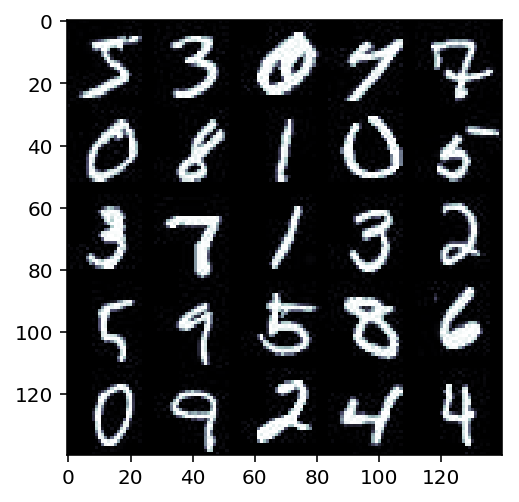

In [13]:
hide_code
show_n_images = 25
"""DON'T MODIFY ANYTHING IN THIS CELL"""

mnist_images = get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(images_square_grid(mnist_images, 'L'), cmap=cm.bone);

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

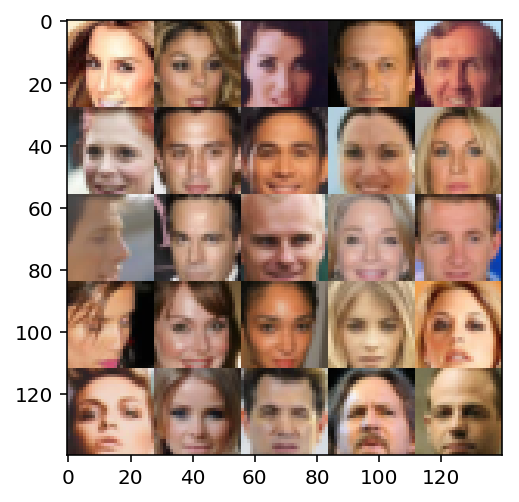

In [14]:
hide_code
"""DON'T MODIFY ANYTHING IN THIS CELL"""

celeba_images = get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(images_square_grid(celeba_images, 'RGB'));

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.

- The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  
- The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [15]:
hide_code
"""DON'T MODIFY ANYTHING IN THIS CELL"""

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), \
'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: No GPU found. Please use a GPU to train your neural network.
  # Remove the CWD from sys.path while we load stuff.


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [48]:
hide_code
alpha0 = 0.1 # for leaky_relu activation
stddev0 = 0.01 # for initializers

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    
    input_real = tf.placeholder(tf.float32, 
                                shape=[None, image_width, image_height, image_channels], # rank 4
                                name="Real_Input") 
    
    input_z = tf.placeholder(tf.float32, shape=[None, z_dim], name="Z_Input") # rank 2    
    input_learning_rate = tf.placeholder(tf.float32, shape=[], name="Learning_Rate") # rank 0
    
    return input_real, input_z, input_learning_rate

"""DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE"""
test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [49]:
hide_code
def discriminator(images, reuse=False, alpha=alpha0):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    
    with tf.variable_scope('discriminator', reuse=reuse):
        # image shape [28,28,3]
        x = tf.layers.conv2d(images, 32, 5, strides=2, 
                             activation=tf.nn.relu,
                             kernel_initializer=tf.random_normal_initializer(stddev=stddev0), 
                             padding='same')
        
        # input shape [14,14,32]       
        x = tf.layers.conv2d(x, 96, 5, strides=2, activation=tf.nn.relu,
                             kernel_initializer=tf.random_normal_initializer(stddev=stddev0), 
                             padding='same')      
        x = tf.layers.batch_normalization(x, training=True)

        # input shape [7,7,96]        
        x = tf.layers.conv2d(x, 128, 5, strides=2, activation=tf.nn.relu,
                             kernel_initializer=tf.random_normal_initializer(stddev=stddev0), 
                             padding='same')  
        x = tf.layers.batch_normalization(x, training=True)

        # input shape [4,4,128]       
        x = tf.reshape(x, (-1, 4*4*128))
        
        discriminator_logits = tf.layers.dense(x, 1)
        discriminator_outputs = tf.sigmoid(discriminator_logits)
        
    return discriminator_outputs, discriminator_logits

"""DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE"""
test_discriminator(discriminator, tf)

Tests Passed


In [50]:
hide_code
def discriminator_l(images, reuse=False, alpha=alpha0):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    
    with tf.variable_scope('discriminator', reuse=reuse):
        # image shape [28,28,3]
        x = tf.layers.conv2d(images, 32, 5, strides=2,
                             kernel_initializer=tf.random_normal_initializer(stddev=stddev0), 
                             padding='same')
        x = tf.maximum(x * alpha, x) # leaky_relu activation 
        
        # input shape [14,14,32]       
        x = tf.layers.conv2d(x, 96, 5, strides=2,
                             kernel_initializer=tf.random_normal_initializer(stddev=stddev0), 
                             padding='same')
        x = tf.maximum(x * alpha, x) # leaky_relu activation       
        x = tf.layers.batch_normalization(x, training=True)

        # input shape [7,7,96]        
        x = tf.layers.conv2d(x, 128, 5, strides=2,
                             kernel_initializer=tf.random_normal_initializer(stddev=stddev0), 
                             padding='same')
        x = tf.maximum(x * alpha, x) # leaky_relu activation       
        x = tf.layers.batch_normalization(x, training=True)

        # input shape [4,4,128]       
        x = tf.reshape(x, (-1, 4*4*128))
        
        discriminator_logits = tf.layers.dense(x, 1)
        discriminator_outputs = tf.sigmoid(discriminator_logits)
        
    return discriminator_outputs, discriminator_logits

"""DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE"""
test_discriminator(discriminator_l, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [51]:
hide_code
def generator(z, out_channel_dim, is_train=True, alpha=alpha0):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    
    with tf.variable_scope('generator', reuse=(not is_train)):
        
        x = tf.layers.dense(z, 7*7*128, activation=tf.nn.relu)
        x = tf.reshape(x, (-1, 7, 7, 128))
        
        x = tf.layers.batch_normalization(x, training=is_train)
        
        # input shape [7,7,128]       
        x = tf.layers.conv2d_transpose(x, 96, 5, strides=2, activation=tf.nn.relu,
                                       kernel_initializer=tf.random_normal_initializer(stddev=stddev0), 
                                       padding='same')
        
        x = tf.layers.batch_normalization(x, training=is_train)

        # input shape [14,14,96]
        x = tf.layers.conv2d_transpose(x, 32, 5, strides=2, activation=tf.nn.relu,
                                       kernel_initializer=tf.random_normal_initializer(stddev=stddev0), 
                                       padding='same')
        
        x = tf.layers.batch_normalization(x, training=is_train)

        # input shape [28,28,32]        
        generator_logits = \
        tf.layers.conv2d_transpose(x, out_channel_dim, 3, strides=1, 
                                   kernel_initializer=tf.random_normal_initializer(stddev=stddev0), 
                                   padding='same')

        # input shape [28,28,3]         
        generator_outputs = tf.tanh(generator_logits)
    
    return generator_outputs    

"""DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE"""
test_generator(generator, tf)

Tests Passed


In [52]:
hide_code
def generator_l(z, out_channel_dim, is_train=True, alpha=alpha0):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    
    with tf.variable_scope('generator', reuse=(not is_train)):
        
        x = tf.layers.dense(z, 7*7*128)
        x = tf.reshape(x, (-1, 7, 7, 128))
        x = tf.maximum(x * alpha, x) # leaky_relu activation 
        
        x = tf.layers.batch_normalization(x, training=is_train)
        
        # input shape [7,7,128]       
        x = tf.layers.conv2d_transpose(x, 96, 5, strides=2, 
                                       kernel_initializer=tf.random_normal_initializer(stddev=stddev0), 
                                       padding='same')
        x = tf.maximum(x * alpha, x) # leaky_relu activation 
        
        x = tf.layers.batch_normalization(x, training=is_train)

        # input shape [14,14,96]
        x = tf.layers.conv2d_transpose(x, 32, 5, strides=2,
                                       kernel_initializer=tf.random_normal_initializer(stddev=stddev0), 
                                       padding='same')
        x = tf.maximum(x * alpha, x) # leaky_relu activation 
            
        x = tf.layers.batch_normalization(x, training=is_train)

        # input shape [28,28,32]        
        generator_logits = \
        tf.layers.conv2d_transpose(x, out_channel_dim, 3, strides=1, 
                                   kernel_initializer=tf.random_normal_initializer(stddev=stddev0), 
                                   padding='same')

        # input shape [28,28,3]         
        generator_outputs = tf.tanh(generator_logits)
    
    return generator_outputs    

"""DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE"""
test_generator(generator_l, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [53]:
hide_code
def model_loss(input_real, input_z, out_channel_dim, alpha=alpha0, index="leaky_relu"):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    
    if index=="relu":
        img_generator = generator(input_z, out_channel_dim, is_train=True, alpha=alpha)
        real_outputs, real_logits = discriminator(input_real, reuse=False, alpha=alpha)
        generator_outputs, generator_logits = discriminator(img_generator, reuse=True, alpha=alpha)
    elif index=="leaky_relu":
        img_generator = generator_l(input_z, out_channel_dim, is_train=True, alpha=alpha)
        real_outputs, real_logits = discriminator_l(input_real, alpha=alpha)
        generator_outputs, generator_logits = discriminator_l(img_generator, reuse=True, alpha=alpha)        
    
    real_labels = tf.ones_like(real_outputs) * (1 - alpha)
    zeros_labels = tf.zeros_like(generator_outputs)
    ones_labels = tf.ones_like(generator_outputs)

    real_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=real_logits, 
                                                                       labels=real_labels))
    zeros_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=generator_logits, 
                                                                        labels=zeros_labels))
    ones_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=generator_logits, 
                                                                       labels=ones_labels))

    return real_loss + zeros_loss, ones_loss

"""DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE"""
test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [54]:
hide_code
def model_opt(discriminator_loss, generator_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    
    trainable_variables = tf.trainable_variables()
    discriminator_trainable_variables = \
    [v for v in trainable_variables if v.name.startswith('discriminator')]
    generator_trainable_variables = \
    [v for v in trainable_variables if v.name.startswith('generator')]
    
    update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
    discriminator_update_ops = \
    [u for u in update_ops if u.name.startswith('discriminator')]
    generator_update_ops = \
    [u for u in update_ops if u.name.startswith('generator')]

    with tf.control_dependencies(discriminator_update_ops):
        discriminator_training_operations = tf.train.AdamOptimizer(learning_rate=learning_rate, beta1=beta1).\
        minimize(discriminator_loss, var_list=discriminator_trainable_variables)

    with tf.control_dependencies(generator_update_ops):
        generator_training_operations = tf.train.AdamOptimizer(learning_rate=learning_rate, beta1=beta1).\
        minimize(generator_loss, var_list=generator_trainable_variables)
            
    return discriminator_training_operations, generator_training_operations

"""DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE"""
test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [55]:
hide_code
"""DON'T MODIFY ANYTHING IN THIS CELL"""

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(generator(input_z, out_channel_dim, False),
                       feed_dict={input_z: example_z})

    images_grid = images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [69]:
hide_code
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, 
          get_batches, data_shape, data_image_mode, print_step, show_step):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    
    input_real, input_z, input_learning_rate = \
    model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    
    discriminator_loss, generator_loss = \
    model_loss(input_real, input_z, data_shape[3], alpha=alpha0, index="leaky_relu")
    
    discriminator_training_operations, generator_training_operations = \
    model_opt(discriminator_loss, generator_loss, learning_rate, beta1)
    
    train_step = 0
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                
                train_step += 1
                batch_images *= 2.0                
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                _ = sess.run(discriminator_training_operations, 
                             feed_dict={input_real: batch_images, input_z: batch_z})
                _ = sess.run(generator_training_operations, 
                             feed_dict={input_z: batch_z})

                if train_step % print_step == 0:
                    discriminator_training_loss = \
                    discriminator_loss.eval({input_real: batch_images, input_z: batch_z})
                    generator_training_loss= \
                    generator_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}| Step {}|".format(epoch_i + 1, epochs, train_step),
                          "Discriminator Loss:{:.5f}|".format(discriminator_training_loss),
                          "Generator Loss:{:.5f}|".format(generator_training_loss),
                          "Discriminator Loss>Generator Loss: {}"\
                          .format(discriminator_training_loss>generator_training_loss))

                if train_step % show_step == 0:
                    show_generator_output(sess, 25, input_z, data_shape[3], data_image_mode)
                    
        show_generator_output(sess, 25, input_z, data_shape[3], data_image_mode)

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2|Step 20| Discriminator Loss: 0.39370| Generator Loss: 2.84054| Discriminator Loss > Generator Loss: False
Epoch 1/2|Step 40| Discriminator Loss: 0.35339| Generator Loss: 4.22807| Discriminator Loss > Generator Loss: False
Epoch 1/2|Step 60| Discriminator Loss: 0.34791| Generator Loss: 4.86849| Discriminator Loss > Generator Loss: False
Epoch 1/2|Step 80| Discriminator Loss: 0.33418| Generator Loss: 6.23465| Discriminator Loss > Generator Loss: False
Epoch 1/2|Step 100| Discriminator Loss: 0.35183| Generator Loss: 5.36964| Discriminator Loss > Generator Loss: False
Epoch 1/2|Step 120| Discriminator Loss: 0.35800| Generator Loss: 5.47329| Discriminator Loss > Generator Loss: False
Epoch 1/2|Step 140| Discriminator Loss: 0.35332| Generator Loss: 5.59598| Discriminator Loss > Generator Loss: False
Epoch 1/2|Step 160| Discriminator Loss: 0.37927| Generator Loss: 4.78015| Discriminator Loss > Generator Loss: False
Epoch 1/2|Step 180| Discriminator Loss: 0.37133| Generator Loss: 4.5

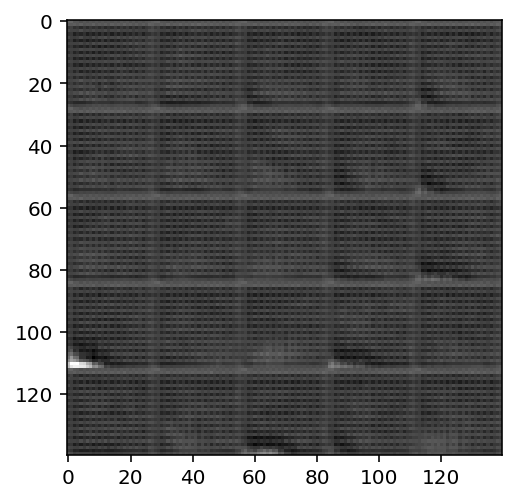

Epoch 1/2|Step 220| Discriminator Loss: 0.39436| Generator Loss: 3.86000| Discriminator Loss > Generator Loss: False
Epoch 1/2|Step 240| Discriminator Loss: 0.47078| Generator Loss: 3.16374| Discriminator Loss > Generator Loss: False
Epoch 1/2|Step 260| Discriminator Loss: 0.38421| Generator Loss: 5.76683| Discriminator Loss > Generator Loss: False
Epoch 1/2|Step 280| Discriminator Loss: 0.38843| Generator Loss: 3.34571| Discriminator Loss > Generator Loss: False
Epoch 1/2|Step 300| Discriminator Loss: 0.49994| Generator Loss: 2.56509| Discriminator Loss > Generator Loss: False
Epoch 1/2|Step 320| Discriminator Loss: 0.62211| Generator Loss: 1.55952| Discriminator Loss > Generator Loss: False
Epoch 1/2|Step 340| Discriminator Loss: 0.53757| Generator Loss: 2.14241| Discriminator Loss > Generator Loss: False
Epoch 1/2|Step 360| Discriminator Loss: 0.42775| Generator Loss: 3.75162| Discriminator Loss > Generator Loss: False
Epoch 1/2|Step 380| Discriminator Loss: 0.55988| Generator Loss:

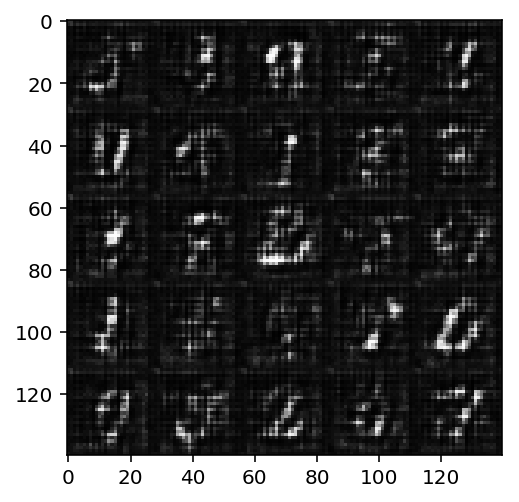

Epoch 1/2|Step 420| Discriminator Loss: 0.75089| Generator Loss: 2.93109| Discriminator Loss > Generator Loss: False
Epoch 1/2|Step 440| Discriminator Loss: 0.53764| Generator Loss: 1.93383| Discriminator Loss > Generator Loss: False
Epoch 1/2|Step 460| Discriminator Loss: 0.67834| Generator Loss: 2.85049| Discriminator Loss > Generator Loss: False
Epoch 1/2|Step 480| Discriminator Loss: 0.59345| Generator Loss: 2.04277| Discriminator Loss > Generator Loss: False
Epoch 1/2|Step 500| Discriminator Loss: 0.55441| Generator Loss: 2.53832| Discriminator Loss > Generator Loss: False
Epoch 1/2|Step 520| Discriminator Loss: 0.63858| Generator Loss: 1.63441| Discriminator Loss > Generator Loss: False
Epoch 1/2|Step 540| Discriminator Loss: 0.56051| Generator Loss: 2.10337| Discriminator Loss > Generator Loss: False
Epoch 1/2|Step 560| Discriminator Loss: 0.64725| Generator Loss: 1.68077| Discriminator Loss > Generator Loss: False
Epoch 1/2|Step 580| Discriminator Loss: 0.55218| Generator Loss:

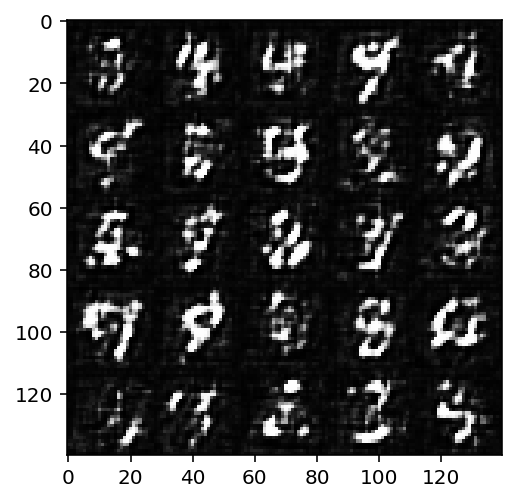

Epoch 1/2|Step 620| Discriminator Loss: 0.65904| Generator Loss: 3.36067| Discriminator Loss > Generator Loss: False
Epoch 1/2|Step 640| Discriminator Loss: 0.54050| Generator Loss: 2.58030| Discriminator Loss > Generator Loss: False
Epoch 1/2|Step 660| Discriminator Loss: 0.62291| Generator Loss: 1.87115| Discriminator Loss > Generator Loss: False
Epoch 1/2|Step 680| Discriminator Loss: 0.67935| Generator Loss: 1.63448| Discriminator Loss > Generator Loss: False
Epoch 1/2|Step 700| Discriminator Loss: 0.66239| Generator Loss: 2.52493| Discriminator Loss > Generator Loss: False
Epoch 1/2|Step 720| Discriminator Loss: 0.69875| Generator Loss: 1.62428| Discriminator Loss > Generator Loss: False
Epoch 1/2|Step 740| Discriminator Loss: 0.61732| Generator Loss: 2.81083| Discriminator Loss > Generator Loss: False
Epoch 1/2|Step 760| Discriminator Loss: 0.70873| Generator Loss: 1.62656| Discriminator Loss > Generator Loss: False
Epoch 1/2|Step 780| Discriminator Loss: 0.85609| Generator Loss:

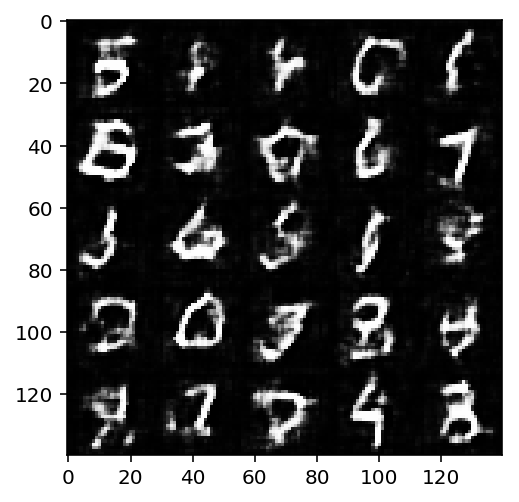

Epoch 1/2|Step 820| Discriminator Loss: 0.71442| Generator Loss: 2.03138| Discriminator Loss > Generator Loss: False
Epoch 1/2|Step 840| Discriminator Loss: 0.63358| Generator Loss: 1.86607| Discriminator Loss > Generator Loss: False
Epoch 1/2|Step 860| Discriminator Loss: 0.98645| Generator Loss: 1.02448| Discriminator Loss > Generator Loss: False
Epoch 1/2|Step 880| Discriminator Loss: 0.77300| Generator Loss: 1.39454| Discriminator Loss > Generator Loss: False
Epoch 1/2|Step 900| Discriminator Loss: 0.90205| Generator Loss: 1.22255| Discriminator Loss > Generator Loss: False
Epoch 1/2|Step 920| Discriminator Loss: 0.70535| Generator Loss: 1.66615| Discriminator Loss > Generator Loss: False
Epoch 2/2|Step 940| Discriminator Loss: 0.78849| Generator Loss: 1.44771| Discriminator Loss > Generator Loss: False
Epoch 2/2|Step 960| Discriminator Loss: 0.82808| Generator Loss: 1.31054| Discriminator Loss > Generator Loss: False
Epoch 2/2|Step 980| Discriminator Loss: 0.98492| Generator Loss:

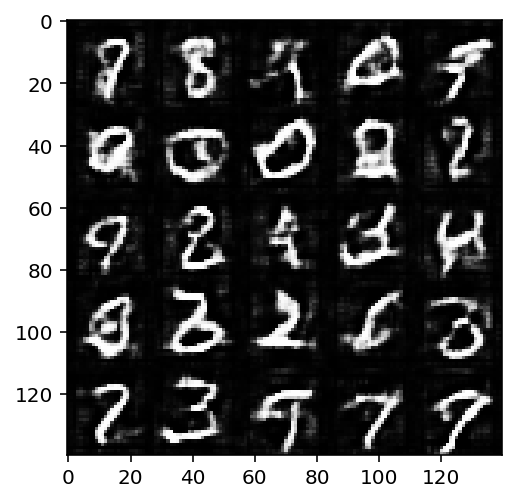

Epoch 2/2|Step 1020| Discriminator Loss: 0.76012| Generator Loss: 1.46517| Discriminator Loss > Generator Loss: False
Epoch 2/2|Step 1040| Discriminator Loss: 0.91201| Generator Loss: 1.13949| Discriminator Loss > Generator Loss: False
Epoch 2/2|Step 1060| Discriminator Loss: 0.96683| Generator Loss: 1.07317| Discriminator Loss > Generator Loss: False
Epoch 2/2|Step 1080| Discriminator Loss: 0.93953| Generator Loss: 1.18078| Discriminator Loss > Generator Loss: False
Epoch 2/2|Step 1100| Discriminator Loss: 0.97199| Generator Loss: 0.97678| Discriminator Loss > Generator Loss: False
Epoch 2/2|Step 1120| Discriminator Loss: 0.78195| Generator Loss: 2.13513| Discriminator Loss > Generator Loss: False
Epoch 2/2|Step 1140| Discriminator Loss: 0.87756| Generator Loss: 1.82770| Discriminator Loss > Generator Loss: False
Epoch 2/2|Step 1160| Discriminator Loss: 0.82146| Generator Loss: 1.42368| Discriminator Loss > Generator Loss: False
Epoch 2/2|Step 1180| Discriminator Loss: 0.98413| Genera

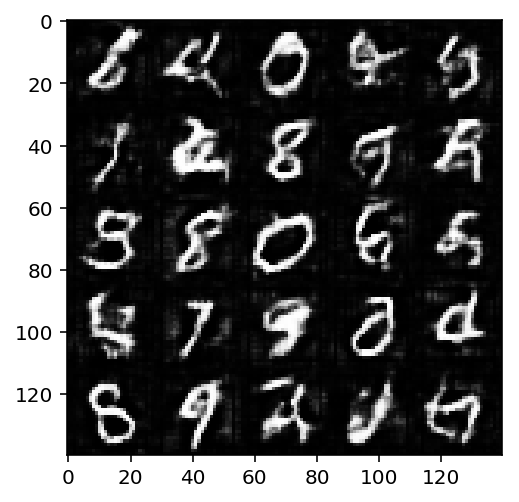

Epoch 2/2|Step 1220| Discriminator Loss: 0.86231| Generator Loss: 1.97417| Discriminator Loss > Generator Loss: False
Epoch 2/2|Step 1240| Discriminator Loss: 0.78866| Generator Loss: 1.37801| Discriminator Loss > Generator Loss: False
Epoch 2/2|Step 1260| Discriminator Loss: 0.93202| Generator Loss: 1.82406| Discriminator Loss > Generator Loss: False
Epoch 2/2|Step 1280| Discriminator Loss: 1.03981| Generator Loss: 0.91960| Discriminator Loss > Generator Loss: True
Epoch 2/2|Step 1300| Discriminator Loss: 1.07727| Generator Loss: 1.89923| Discriminator Loss > Generator Loss: False
Epoch 2/2|Step 1320| Discriminator Loss: 0.98745| Generator Loss: 1.39842| Discriminator Loss > Generator Loss: False
Epoch 2/2|Step 1340| Discriminator Loss: 0.78616| Generator Loss: 1.86499| Discriminator Loss > Generator Loss: False
Epoch 2/2|Step 1360| Discriminator Loss: 0.88050| Generator Loss: 1.22571| Discriminator Loss > Generator Loss: False
Epoch 2/2|Step 1380| Discriminator Loss: 0.89658| Generat

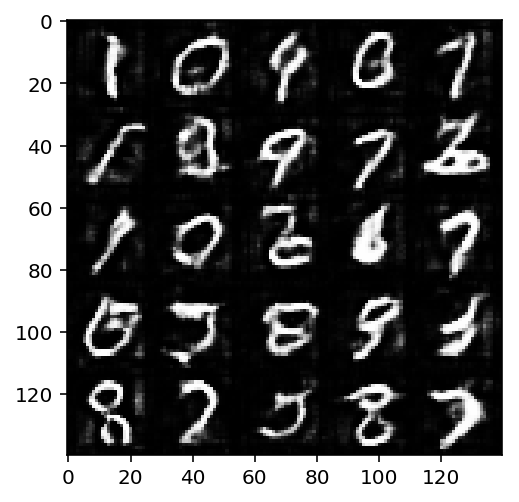

Epoch 2/2|Step 1420| Discriminator Loss: 0.80629| Generator Loss: 1.38060| Discriminator Loss > Generator Loss: False
Epoch 2/2|Step 1440| Discriminator Loss: 0.67529| Generator Loss: 1.60091| Discriminator Loss > Generator Loss: False
Epoch 2/2|Step 1460| Discriminator Loss: 0.84973| Generator Loss: 1.31485| Discriminator Loss > Generator Loss: False
Epoch 2/2|Step 1480| Discriminator Loss: 0.94278| Generator Loss: 1.21942| Discriminator Loss > Generator Loss: False
Epoch 2/2|Step 1500| Discriminator Loss: 0.73174| Generator Loss: 1.71334| Discriminator Loss > Generator Loss: False
Epoch 2/2|Step 1520| Discriminator Loss: 0.76782| Generator Loss: 1.71792| Discriminator Loss > Generator Loss: False
Epoch 2/2|Step 1540| Discriminator Loss: 0.78055| Generator Loss: 1.28719| Discriminator Loss > Generator Loss: False
Epoch 2/2|Step 1560| Discriminator Loss: 0.91460| Generator Loss: 2.17227| Discriminator Loss > Generator Loss: False
Epoch 2/2|Step 1580| Discriminator Loss: 0.87724| Genera

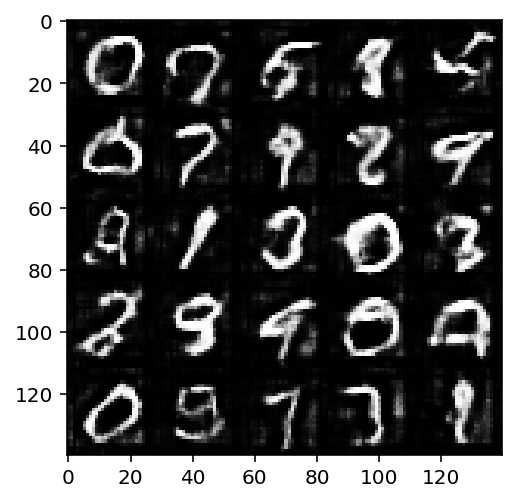

Epoch 2/2|Step 1620| Discriminator Loss: 0.87353| Generator Loss: 1.15221| Discriminator Loss > Generator Loss: False
Epoch 2/2|Step 1640| Discriminator Loss: 0.88422| Generator Loss: 1.40801| Discriminator Loss > Generator Loss: False
Epoch 2/2|Step 1660| Discriminator Loss: 0.86733| Generator Loss: 1.24497| Discriminator Loss > Generator Loss: False
Epoch 2/2|Step 1680| Discriminator Loss: 0.73297| Generator Loss: 1.75755| Discriminator Loss > Generator Loss: False
Epoch 2/2|Step 1700| Discriminator Loss: 0.89861| Generator Loss: 1.11896| Discriminator Loss > Generator Loss: False
Epoch 2/2|Step 1720| Discriminator Loss: 1.21469| Generator Loss: 0.70971| Discriminator Loss > Generator Loss: True
Epoch 2/2|Step 1740| Discriminator Loss: 0.83704| Generator Loss: 1.42268| Discriminator Loss > Generator Loss: False
Epoch 2/2|Step 1760| Discriminator Loss: 0.92603| Generator Loss: 1.85021| Discriminator Loss > Generator Loss: False
Epoch 2/2|Step 1780| Discriminator Loss: 0.77553| Generat

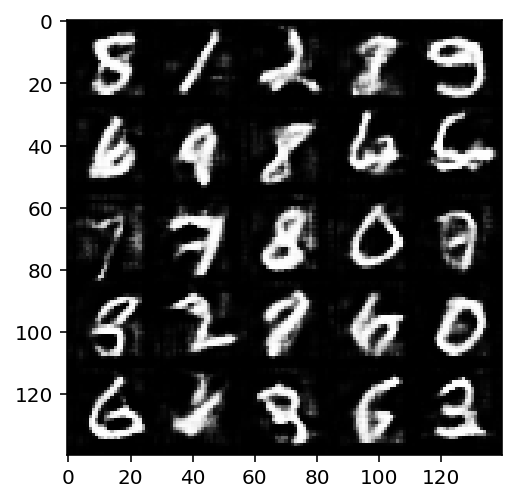

Epoch 2/2|Step 1820| Discriminator Loss: 1.07816| Generator Loss: 0.89780| Discriminator Loss > Generator Loss: True
Epoch 2/2|Step 1840| Discriminator Loss: 0.85986| Generator Loss: 1.59506| Discriminator Loss > Generator Loss: False
Epoch 2/2|Step 1860| Discriminator Loss: 0.83188| Generator Loss: 1.28127| Discriminator Loss > Generator Loss: False


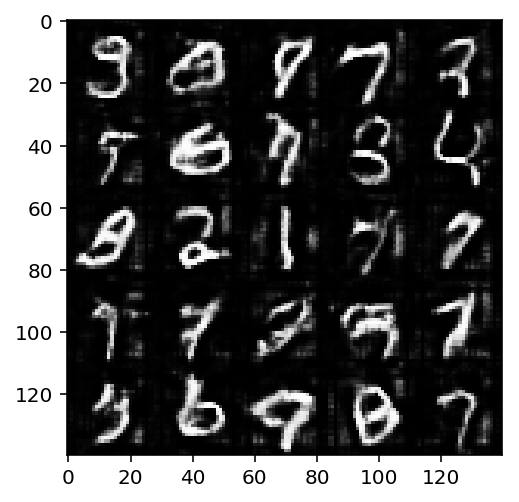

In [67]:
hide_code
batch_size = 64
z_dim = 128
learning_rate = 0.0001
beta1 = 0.5

"""DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE"""
epochs = 2

mnist_dataset = Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, 
          mnist_dataset.get_batches, mnist_dataset.shape, mnist_dataset.image_mode, 20, 200)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1|Step 20| Discriminator Loss: 0.67015| Generator Loss: 1.36417| Discriminator Loss > Generator Loss: False
Epoch 1/1|Step 40| Discriminator Loss: 0.45267| Generator Loss: 2.66535| Discriminator Loss > Generator Loss: False
Epoch 1/1|Step 60| Discriminator Loss: 0.40092| Generator Loss: 3.02684| Discriminator Loss > Generator Loss: False
Epoch 1/1|Step 80| Discriminator Loss: 0.37962| Generator Loss: 5.28284| Discriminator Loss > Generator Loss: False
Epoch 1/1|Step 100| Discriminator Loss: 0.36587| Generator Loss: 4.15252| Discriminator Loss > Generator Loss: False
Epoch 1/1|Step 120| Discriminator Loss: 0.36790| Generator Loss: 4.37120| Discriminator Loss > Generator Loss: False
Epoch 1/1|Step 140| Discriminator Loss: 0.40232| Generator Loss: 3.06908| Discriminator Loss > Generator Loss: False
Epoch 1/1|Step 160| Discriminator Loss: 0.37796| Generator Loss: 3.96936| Discriminator Loss > Generator Loss: False
Epoch 1/1|Step 180| Discriminator Loss: 0.51611| Generator Loss: 4.7

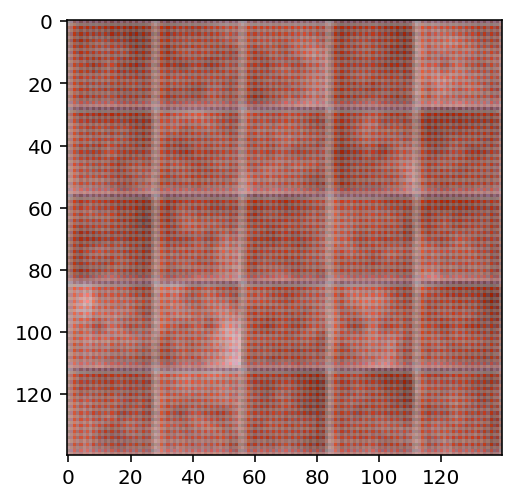

Epoch 1/1|Step 220| Discriminator Loss: 0.58098| Generator Loss: 2.71555| Discriminator Loss > Generator Loss: False
Epoch 1/1|Step 240| Discriminator Loss: 0.59093| Generator Loss: 1.97296| Discriminator Loss > Generator Loss: False
Epoch 1/1|Step 260| Discriminator Loss: 0.99096| Generator Loss: 3.11691| Discriminator Loss > Generator Loss: False
Epoch 1/1|Step 280| Discriminator Loss: 1.13064| Generator Loss: 0.86221| Discriminator Loss > Generator Loss: True
Epoch 1/1|Step 300| Discriminator Loss: 0.96058| Generator Loss: 2.09070| Discriminator Loss > Generator Loss: False
Epoch 1/1|Step 320| Discriminator Loss: 0.81340| Generator Loss: 1.35382| Discriminator Loss > Generator Loss: False
Epoch 1/1|Step 340| Discriminator Loss: 1.00894| Generator Loss: 1.41540| Discriminator Loss > Generator Loss: False
Epoch 1/1|Step 360| Discriminator Loss: 0.80766| Generator Loss: 1.80181| Discriminator Loss > Generator Loss: False
Epoch 1/1|Step 380| Discriminator Loss: 0.84756| Generator Loss: 

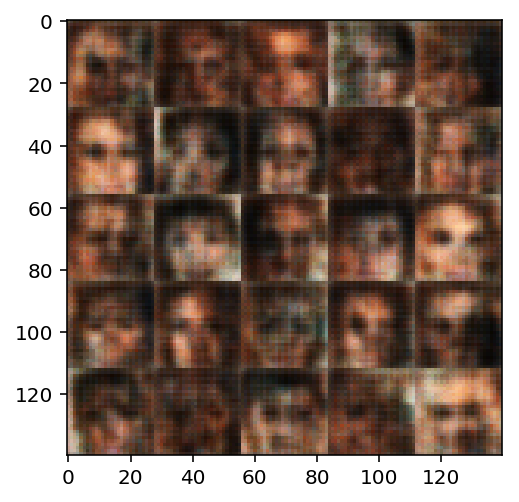

Epoch 1/1|Step 420| Discriminator Loss: 0.81918| Generator Loss: 1.60555| Discriminator Loss > Generator Loss: False
Epoch 1/1|Step 440| Discriminator Loss: 0.76723| Generator Loss: 1.39547| Discriminator Loss > Generator Loss: False
Epoch 1/1|Step 460| Discriminator Loss: 1.56257| Generator Loss: 0.42972| Discriminator Loss > Generator Loss: True
Epoch 1/1|Step 480| Discriminator Loss: 0.82966| Generator Loss: 1.19237| Discriminator Loss > Generator Loss: False
Epoch 1/1|Step 500| Discriminator Loss: 0.75790| Generator Loss: 1.58603| Discriminator Loss > Generator Loss: False
Epoch 1/1|Step 520| Discriminator Loss: 0.93011| Generator Loss: 1.08193| Discriminator Loss > Generator Loss: False
Epoch 1/1|Step 540| Discriminator Loss: 1.28006| Generator Loss: 0.60783| Discriminator Loss > Generator Loss: True
Epoch 1/1|Step 560| Discriminator Loss: 1.00780| Generator Loss: 0.95981| Discriminator Loss > Generator Loss: True
Epoch 1/1|Step 580| Discriminator Loss: 1.03663| Generator Loss: 1.

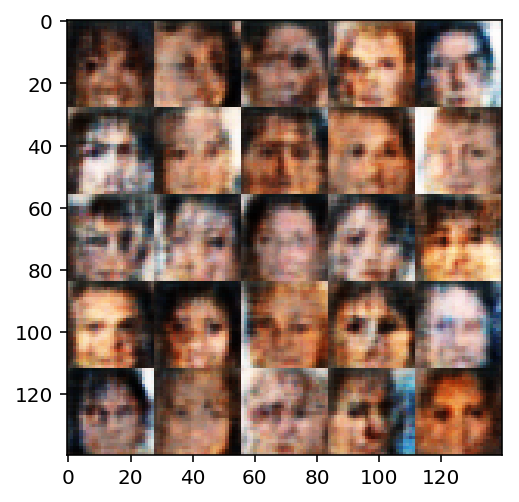

Epoch 1/1|Step 620| Discriminator Loss: 0.83701| Generator Loss: 1.50154| Discriminator Loss > Generator Loss: False
Epoch 1/1|Step 640| Discriminator Loss: 1.13099| Generator Loss: 0.69102| Discriminator Loss > Generator Loss: True
Epoch 1/1|Step 660| Discriminator Loss: 1.04727| Generator Loss: 0.81607| Discriminator Loss > Generator Loss: True
Epoch 1/1|Step 680| Discriminator Loss: 1.01705| Generator Loss: 0.98810| Discriminator Loss > Generator Loss: True
Epoch 1/1|Step 700| Discriminator Loss: 0.92248| Generator Loss: 1.24802| Discriminator Loss > Generator Loss: False
Epoch 1/1|Step 720| Discriminator Loss: 0.98966| Generator Loss: 1.10513| Discriminator Loss > Generator Loss: False
Epoch 1/1|Step 740| Discriminator Loss: 1.05816| Generator Loss: 1.05804| Discriminator Loss > Generator Loss: True
Epoch 1/1|Step 760| Discriminator Loss: 1.01105| Generator Loss: 0.94072| Discriminator Loss > Generator Loss: True
Epoch 1/1|Step 780| Discriminator Loss: 1.06687| Generator Loss: 0.95

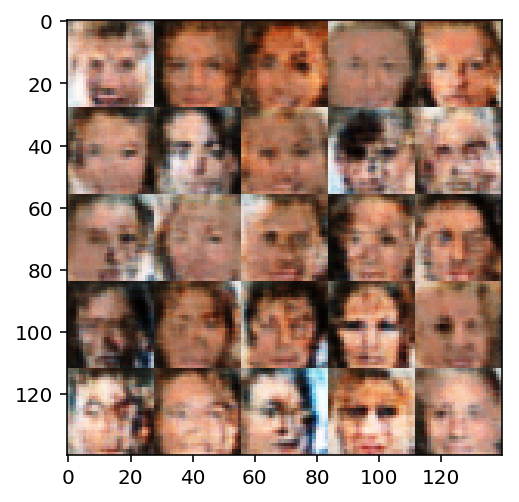

Epoch 1/1|Step 820| Discriminator Loss: 1.03267| Generator Loss: 0.95203| Discriminator Loss > Generator Loss: True
Epoch 1/1|Step 840| Discriminator Loss: 1.15209| Generator Loss: 0.81144| Discriminator Loss > Generator Loss: True
Epoch 1/1|Step 860| Discriminator Loss: 0.93565| Generator Loss: 1.29420| Discriminator Loss > Generator Loss: False
Epoch 1/1|Step 880| Discriminator Loss: 0.97981| Generator Loss: 1.03239| Discriminator Loss > Generator Loss: False
Epoch 1/1|Step 900| Discriminator Loss: 1.22350| Generator Loss: 0.67117| Discriminator Loss > Generator Loss: True
Epoch 1/1|Step 920| Discriminator Loss: 1.06016| Generator Loss: 0.93361| Discriminator Loss > Generator Loss: True
Epoch 1/1|Step 940| Discriminator Loss: 0.96540| Generator Loss: 1.01527| Discriminator Loss > Generator Loss: False
Epoch 1/1|Step 960| Discriminator Loss: 1.07613| Generator Loss: 1.05802| Discriminator Loss > Generator Loss: True
Epoch 1/1|Step 980| Discriminator Loss: 1.01048| Generator Loss: 1.21

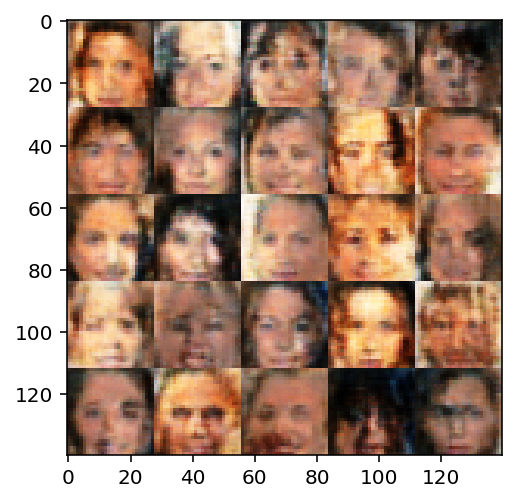

Epoch 1/1|Step 1020| Discriminator Loss: 0.96095| Generator Loss: 1.30759| Discriminator Loss > Generator Loss: False
Epoch 1/1|Step 1040| Discriminator Loss: 0.98724| Generator Loss: 1.35664| Discriminator Loss > Generator Loss: False
Epoch 1/1|Step 1060| Discriminator Loss: 1.02965| Generator Loss: 0.91762| Discriminator Loss > Generator Loss: True
Epoch 1/1|Step 1080| Discriminator Loss: 1.05267| Generator Loss: 0.76291| Discriminator Loss > Generator Loss: True
Epoch 1/1|Step 1100| Discriminator Loss: 0.93710| Generator Loss: 1.00955| Discriminator Loss > Generator Loss: False
Epoch 1/1|Step 1120| Discriminator Loss: 0.94746| Generator Loss: 1.06334| Discriminator Loss > Generator Loss: False
Epoch 1/1|Step 1140| Discriminator Loss: 1.13850| Generator Loss: 0.74544| Discriminator Loss > Generator Loss: True
Epoch 1/1|Step 1160| Discriminator Loss: 0.95351| Generator Loss: 1.22792| Discriminator Loss > Generator Loss: False
Epoch 1/1|Step 1180| Discriminator Loss: 0.95968| Generator

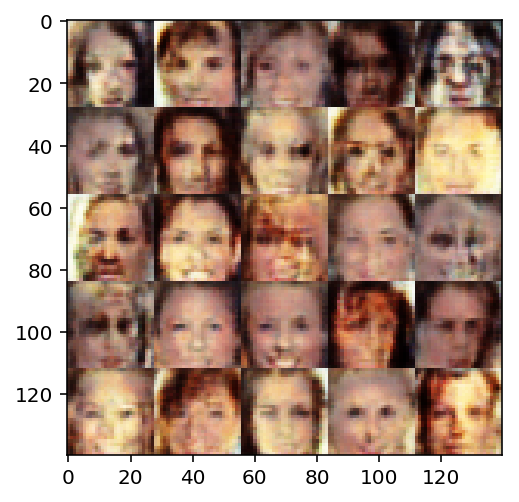

Epoch 1/1|Step 1220| Discriminator Loss: 1.02859| Generator Loss: 1.30413| Discriminator Loss > Generator Loss: False
Epoch 1/1|Step 1240| Discriminator Loss: 0.89492| Generator Loss: 1.37200| Discriminator Loss > Generator Loss: False
Epoch 1/1|Step 1260| Discriminator Loss: 0.91750| Generator Loss: 1.56029| Discriminator Loss > Generator Loss: False
Epoch 1/1|Step 1280| Discriminator Loss: 0.97001| Generator Loss: 1.59279| Discriminator Loss > Generator Loss: False
Epoch 1/1|Step 1300| Discriminator Loss: 1.05981| Generator Loss: 0.84818| Discriminator Loss > Generator Loss: True
Epoch 1/1|Step 1320| Discriminator Loss: 0.90816| Generator Loss: 1.25220| Discriminator Loss > Generator Loss: False
Epoch 1/1|Step 1340| Discriminator Loss: 1.06203| Generator Loss: 0.78436| Discriminator Loss > Generator Loss: True
Epoch 1/1|Step 1360| Discriminator Loss: 0.75444| Generator Loss: 1.76626| Discriminator Loss > Generator Loss: False
Epoch 1/1|Step 1380| Discriminator Loss: 0.92821| Generato

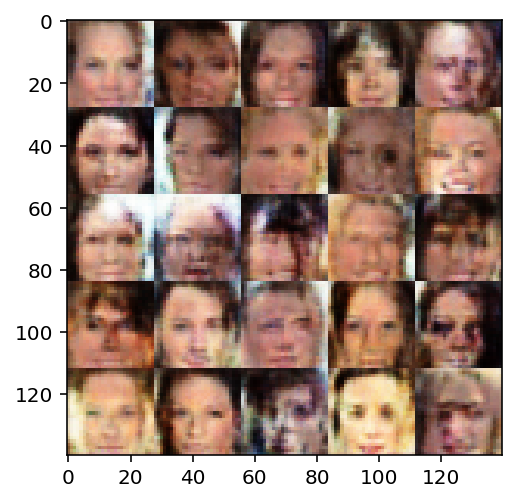

Epoch 1/1|Step 1420| Discriminator Loss: 0.83285| Generator Loss: 1.15524| Discriminator Loss > Generator Loss: False
Epoch 1/1|Step 1440| Discriminator Loss: 0.79709| Generator Loss: 1.41519| Discriminator Loss > Generator Loss: False
Epoch 1/1|Step 1460| Discriminator Loss: 1.07657| Generator Loss: 1.17714| Discriminator Loss > Generator Loss: False
Epoch 1/1|Step 1480| Discriminator Loss: 0.80592| Generator Loss: 1.39235| Discriminator Loss > Generator Loss: False
Epoch 1/1|Step 1500| Discriminator Loss: 0.82031| Generator Loss: 1.41660| Discriminator Loss > Generator Loss: False
Epoch 1/1|Step 1520| Discriminator Loss: 1.02122| Generator Loss: 0.96527| Discriminator Loss > Generator Loss: True
Epoch 1/1|Step 1540| Discriminator Loss: 1.01911| Generator Loss: 0.87729| Discriminator Loss > Generator Loss: True
Epoch 1/1|Step 1560| Discriminator Loss: 0.99635| Generator Loss: 1.12878| Discriminator Loss > Generator Loss: False
Epoch 1/1|Step 1580| Discriminator Loss: 0.85696| Generato

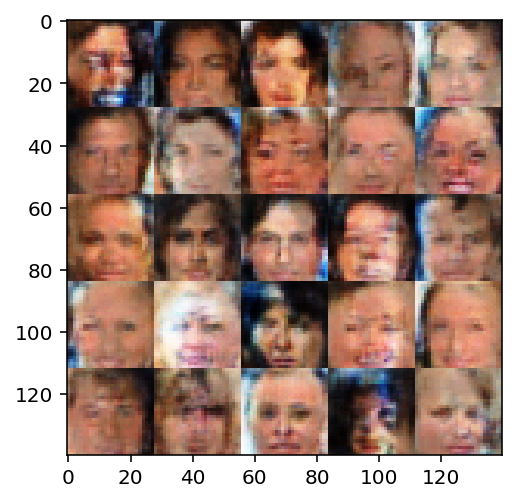

Epoch 1/1|Step 1620| Discriminator Loss: 0.91420| Generator Loss: 1.22503| Discriminator Loss > Generator Loss: False
Epoch 1/1|Step 1640| Discriminator Loss: 1.20708| Generator Loss: 0.83617| Discriminator Loss > Generator Loss: True
Epoch 1/1|Step 1660| Discriminator Loss: 0.96084| Generator Loss: 0.97677| Discriminator Loss > Generator Loss: False
Epoch 1/1|Step 1680| Discriminator Loss: 0.98845| Generator Loss: 1.03883| Discriminator Loss > Generator Loss: False
Epoch 1/1|Step 1700| Discriminator Loss: 1.19409| Generator Loss: 0.70183| Discriminator Loss > Generator Loss: True
Epoch 1/1|Step 1720| Discriminator Loss: 1.00169| Generator Loss: 0.95352| Discriminator Loss > Generator Loss: True
Epoch 1/1|Step 1740| Discriminator Loss: 0.95504| Generator Loss: 1.17140| Discriminator Loss > Generator Loss: False
Epoch 1/1|Step 1760| Discriminator Loss: 1.09290| Generator Loss: 0.87352| Discriminator Loss > Generator Loss: True
Epoch 1/1|Step 1780| Discriminator Loss: 1.13238| Generator 

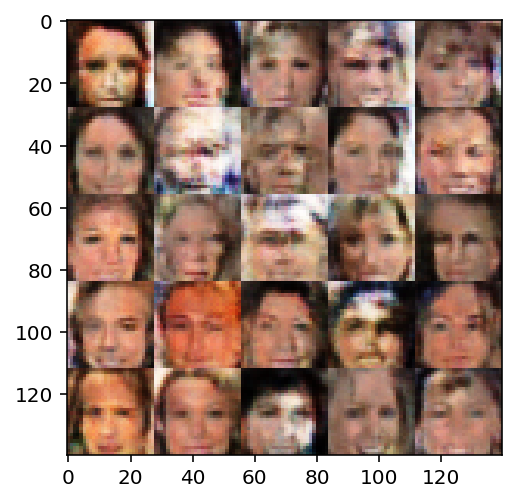

Epoch 1/1|Step 1820| Discriminator Loss: 0.90770| Generator Loss: 1.19949| Discriminator Loss > Generator Loss: False
Epoch 1/1|Step 1840| Discriminator Loss: 0.98755| Generator Loss: 1.12463| Discriminator Loss > Generator Loss: False
Epoch 1/1|Step 1860| Discriminator Loss: 0.95403| Generator Loss: 1.16020| Discriminator Loss > Generator Loss: False
Epoch 1/1|Step 1880| Discriminator Loss: 0.80838| Generator Loss: 1.42063| Discriminator Loss > Generator Loss: False
Epoch 1/1|Step 1900| Discriminator Loss: 0.86704| Generator Loss: 1.30602| Discriminator Loss > Generator Loss: False
Epoch 1/1|Step 1920| Discriminator Loss: 0.87184| Generator Loss: 1.38409| Discriminator Loss > Generator Loss: False
Epoch 1/1|Step 1940| Discriminator Loss: 0.92899| Generator Loss: 1.03523| Discriminator Loss > Generator Loss: False
Epoch 1/1|Step 1960| Discriminator Loss: 0.95288| Generator Loss: 1.05905| Discriminator Loss > Generator Loss: False
Epoch 1/1|Step 1980| Discriminator Loss: 0.97892| Genera

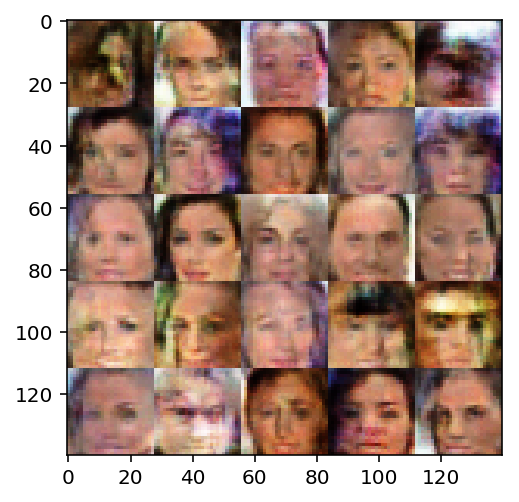

Epoch 1/1|Step 2020| Discriminator Loss: 0.88265| Generator Loss: 1.16436| Discriminator Loss > Generator Loss: False
Epoch 1/1|Step 2040| Discriminator Loss: 0.81572| Generator Loss: 1.30255| Discriminator Loss > Generator Loss: False
Epoch 1/1|Step 2060| Discriminator Loss: 1.15413| Generator Loss: 0.87746| Discriminator Loss > Generator Loss: True
Epoch 1/1|Step 2080| Discriminator Loss: 1.03014| Generator Loss: 0.90610| Discriminator Loss > Generator Loss: True
Epoch 1/1|Step 2100| Discriminator Loss: 1.08101| Generator Loss: 0.81739| Discriminator Loss > Generator Loss: True
Epoch 1/1|Step 2120| Discriminator Loss: 0.92233| Generator Loss: 1.39218| Discriminator Loss > Generator Loss: False
Epoch 1/1|Step 2140| Discriminator Loss: 1.03369| Generator Loss: 1.07742| Discriminator Loss > Generator Loss: False
Epoch 1/1|Step 2160| Discriminator Loss: 1.02152| Generator Loss: 1.12988| Discriminator Loss > Generator Loss: False
Epoch 1/1|Step 2180| Discriminator Loss: 1.02005| Generator

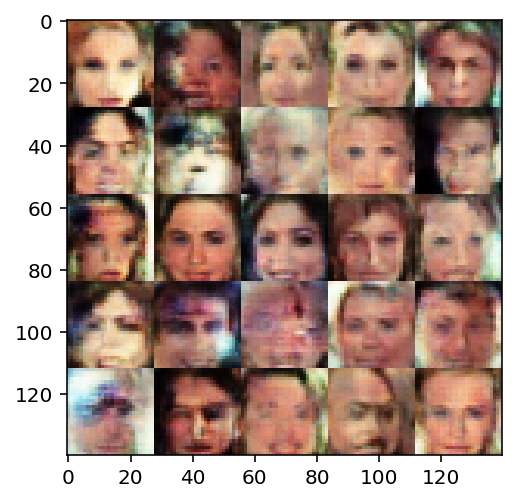

Epoch 1/1|Step 2220| Discriminator Loss: 1.03325| Generator Loss: 0.98760| Discriminator Loss > Generator Loss: True
Epoch 1/1|Step 2240| Discriminator Loss: 1.26364| Generator Loss: 0.64727| Discriminator Loss > Generator Loss: True
Epoch 1/1|Step 2260| Discriminator Loss: 0.94916| Generator Loss: 0.96442| Discriminator Loss > Generator Loss: False
Epoch 1/1|Step 2280| Discriminator Loss: 0.82394| Generator Loss: 1.22811| Discriminator Loss > Generator Loss: False
Epoch 1/1|Step 2300| Discriminator Loss: 0.89438| Generator Loss: 1.08483| Discriminator Loss > Generator Loss: False
Epoch 1/1|Step 2320| Discriminator Loss: 0.87618| Generator Loss: 1.28996| Discriminator Loss > Generator Loss: False
Epoch 1/1|Step 2340| Discriminator Loss: 1.18782| Generator Loss: 0.69924| Discriminator Loss > Generator Loss: True
Epoch 1/1|Step 2360| Discriminator Loss: 1.14441| Generator Loss: 0.83777| Discriminator Loss > Generator Loss: True
Epoch 1/1|Step 2380| Discriminator Loss: 1.06517| Generator 

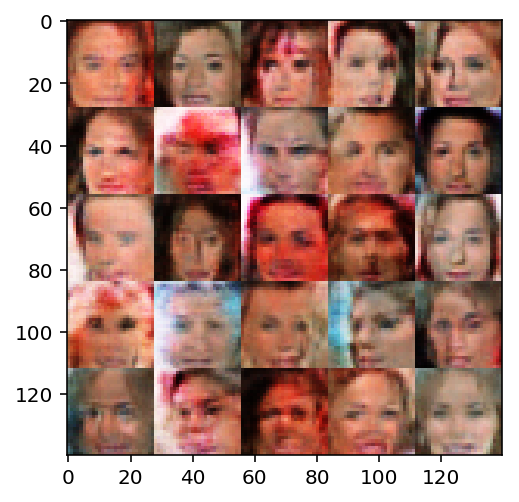

Epoch 1/1|Step 2420| Discriminator Loss: 1.06443| Generator Loss: 0.92159| Discriminator Loss > Generator Loss: True
Epoch 1/1|Step 2440| Discriminator Loss: 1.11051| Generator Loss: 0.83171| Discriminator Loss > Generator Loss: True
Epoch 1/1|Step 2460| Discriminator Loss: 1.28288| Generator Loss: 0.65292| Discriminator Loss > Generator Loss: True
Epoch 1/1|Step 2480| Discriminator Loss: 0.90175| Generator Loss: 1.11762| Discriminator Loss > Generator Loss: False
Epoch 1/1|Step 2500| Discriminator Loss: 1.03423| Generator Loss: 0.93482| Discriminator Loss > Generator Loss: True
Epoch 1/1|Step 2520| Discriminator Loss: 0.96443| Generator Loss: 0.99122| Discriminator Loss > Generator Loss: False
Epoch 1/1|Step 2540| Discriminator Loss: 1.18655| Generator Loss: 0.83190| Discriminator Loss > Generator Loss: True
Epoch 1/1|Step 2560| Discriminator Loss: 1.09318| Generator Loss: 0.86010| Discriminator Loss > Generator Loss: True
Epoch 1/1|Step 2580| Discriminator Loss: 0.87182| Generator Lo

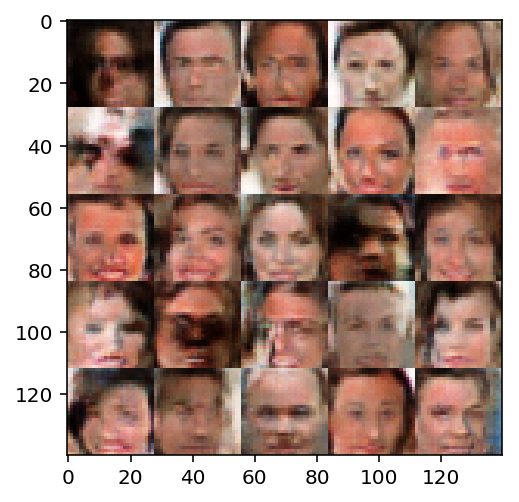

Epoch 1/1|Step 2620| Discriminator Loss: 0.94687| Generator Loss: 1.15283| Discriminator Loss > Generator Loss: False
Epoch 1/1|Step 2640| Discriminator Loss: 0.88530| Generator Loss: 1.27456| Discriminator Loss > Generator Loss: False
Epoch 1/1|Step 2660| Discriminator Loss: 0.86738| Generator Loss: 1.18815| Discriminator Loss > Generator Loss: False
Epoch 1/1|Step 2680| Discriminator Loss: 1.11802| Generator Loss: 0.74154| Discriminator Loss > Generator Loss: True
Epoch 1/1|Step 2700| Discriminator Loss: 0.92668| Generator Loss: 1.16474| Discriminator Loss > Generator Loss: False
Epoch 1/1|Step 2720| Discriminator Loss: 0.84286| Generator Loss: 1.46525| Discriminator Loss > Generator Loss: False
Epoch 1/1|Step 2740| Discriminator Loss: 0.95262| Generator Loss: 1.04280| Discriminator Loss > Generator Loss: False
Epoch 1/1|Step 2760| Discriminator Loss: 1.12566| Generator Loss: 0.88349| Discriminator Loss > Generator Loss: True
Epoch 1/1|Step 2780| Discriminator Loss: 0.99985| Generato

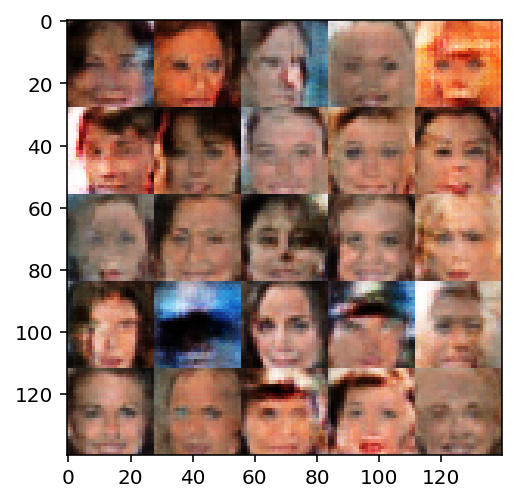

Epoch 1/1|Step 2820| Discriminator Loss: 0.98483| Generator Loss: 1.04851| Discriminator Loss > Generator Loss: False
Epoch 1/1|Step 2840| Discriminator Loss: 1.07104| Generator Loss: 0.81146| Discriminator Loss > Generator Loss: True
Epoch 1/1|Step 2860| Discriminator Loss: 1.00774| Generator Loss: 0.95700| Discriminator Loss > Generator Loss: True
Epoch 1/1|Step 2880| Discriminator Loss: 1.10926| Generator Loss: 1.05612| Discriminator Loss > Generator Loss: True
Epoch 1/1|Step 2900| Discriminator Loss: 0.86104| Generator Loss: 1.19480| Discriminator Loss > Generator Loss: False
Epoch 1/1|Step 2920| Discriminator Loss: 0.94318| Generator Loss: 1.01648| Discriminator Loss > Generator Loss: False
Epoch 1/1|Step 2940| Discriminator Loss: 0.94817| Generator Loss: 1.36994| Discriminator Loss > Generator Loss: False
Epoch 1/1|Step 2960| Discriminator Loss: 1.00256| Generator Loss: 1.22021| Discriminator Loss > Generator Loss: False
Epoch 1/1|Step 2980| Discriminator Loss: 0.77671| Generator

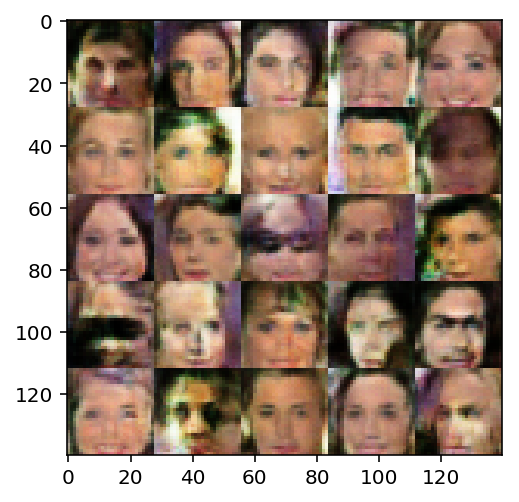

Epoch 1/1|Step 3020| Discriminator Loss: 1.05400| Generator Loss: 0.91128| Discriminator Loss > Generator Loss: True
Epoch 1/1|Step 3040| Discriminator Loss: 1.01069| Generator Loss: 1.02261| Discriminator Loss > Generator Loss: False
Epoch 1/1|Step 3060| Discriminator Loss: 0.90571| Generator Loss: 1.02580| Discriminator Loss > Generator Loss: False
Epoch 1/1|Step 3080| Discriminator Loss: 0.99712| Generator Loss: 0.98539| Discriminator Loss > Generator Loss: True
Epoch 1/1|Step 3100| Discriminator Loss: 1.11060| Generator Loss: 0.82323| Discriminator Loss > Generator Loss: True
Epoch 1/1|Step 3120| Discriminator Loss: 1.09769| Generator Loss: 0.84020| Discriminator Loss > Generator Loss: True
Epoch 1/1|Step 3140| Discriminator Loss: 1.06648| Generator Loss: 0.98666| Discriminator Loss > Generator Loss: True
Epoch 1/1|Step 3160| Discriminator Loss: 0.81996| Generator Loss: 1.32279| Discriminator Loss > Generator Loss: False
Epoch 1/1|Step 3180| Discriminator Loss: 0.93753| Generator L

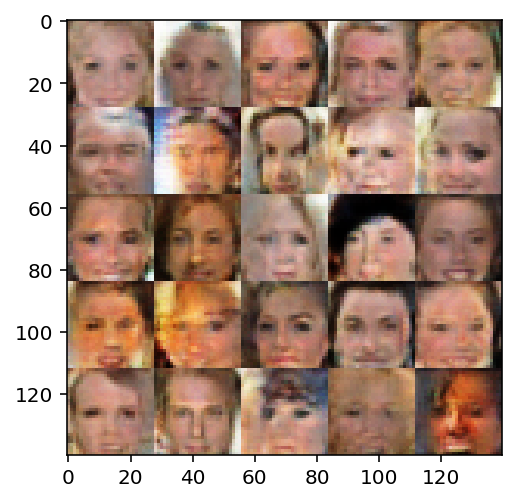

Epoch 1/1|Step 3220| Discriminator Loss: 0.99940| Generator Loss: 0.94492| Discriminator Loss > Generator Loss: True
Epoch 1/1|Step 3240| Discriminator Loss: 0.88535| Generator Loss: 1.11237| Discriminator Loss > Generator Loss: False
Epoch 1/1|Step 3260| Discriminator Loss: 1.08611| Generator Loss: 1.00255| Discriminator Loss > Generator Loss: True
Epoch 1/1|Step 3280| Discriminator Loss: 1.11001| Generator Loss: 0.79133| Discriminator Loss > Generator Loss: True
Epoch 1/1|Step 3300| Discriminator Loss: 0.95387| Generator Loss: 1.26993| Discriminator Loss > Generator Loss: False
Epoch 1/1|Step 3320| Discriminator Loss: 0.97938| Generator Loss: 1.28859| Discriminator Loss > Generator Loss: False
Epoch 1/1|Step 3340| Discriminator Loss: 1.08750| Generator Loss: 0.81153| Discriminator Loss > Generator Loss: True
Epoch 1/1|Step 3360| Discriminator Loss: 0.90011| Generator Loss: 1.26419| Discriminator Loss > Generator Loss: False
Epoch 1/1|Step 3380| Discriminator Loss: 0.92441| Generator 

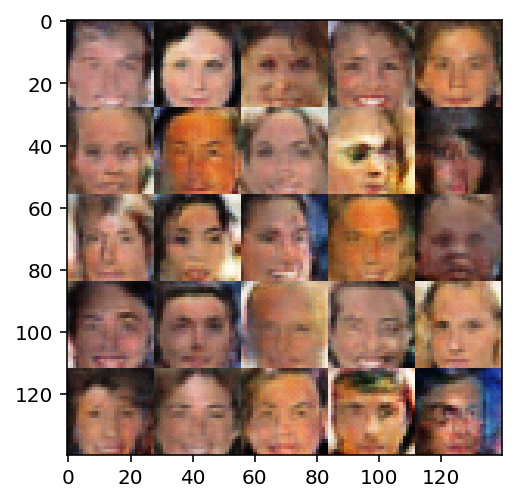

Epoch 1/1|Step 3420| Discriminator Loss: 0.84619| Generator Loss: 1.35494| Discriminator Loss > Generator Loss: False
Epoch 1/1|Step 3440| Discriminator Loss: 1.01243| Generator Loss: 0.91241| Discriminator Loss > Generator Loss: True
Epoch 1/1|Step 3460| Discriminator Loss: 1.04994| Generator Loss: 0.99643| Discriminator Loss > Generator Loss: True
Epoch 1/1|Step 3480| Discriminator Loss: 1.11167| Generator Loss: 0.87099| Discriminator Loss > Generator Loss: True
Epoch 1/1|Step 3500| Discriminator Loss: 0.92449| Generator Loss: 1.07062| Discriminator Loss > Generator Loss: False
Epoch 1/1|Step 3520| Discriminator Loss: 1.05774| Generator Loss: 0.97307| Discriminator Loss > Generator Loss: True
Epoch 1/1|Step 3540| Discriminator Loss: 0.98569| Generator Loss: 1.13095| Discriminator Loss > Generator Loss: False
Epoch 1/1|Step 3560| Discriminator Loss: 1.09280| Generator Loss: 0.94220| Discriminator Loss > Generator Loss: True
Epoch 1/1|Step 3580| Discriminator Loss: 0.92311| Generator L

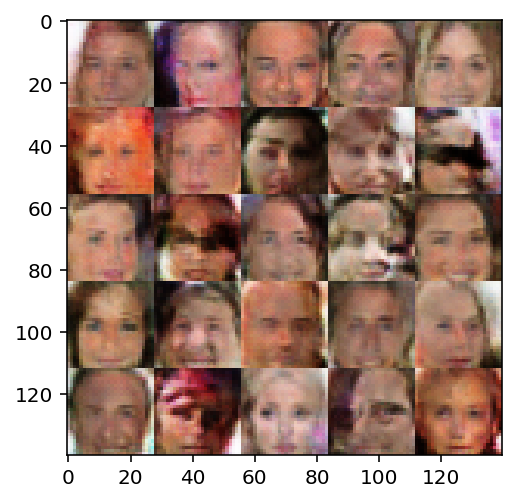

Epoch 1/1|Step 3620| Discriminator Loss: 1.20281| Generator Loss: 0.72346| Discriminator Loss > Generator Loss: True
Epoch 1/1|Step 3640| Discriminator Loss: 1.02546| Generator Loss: 1.13743| Discriminator Loss > Generator Loss: False
Epoch 1/1|Step 3660| Discriminator Loss: 0.95663| Generator Loss: 1.16870| Discriminator Loss > Generator Loss: False
Epoch 1/1|Step 3680| Discriminator Loss: 0.95409| Generator Loss: 1.07990| Discriminator Loss > Generator Loss: False
Epoch 1/1|Step 3700| Discriminator Loss: 0.95816| Generator Loss: 1.05482| Discriminator Loss > Generator Loss: False
Epoch 1/1|Step 3720| Discriminator Loss: 0.90524| Generator Loss: 1.34623| Discriminator Loss > Generator Loss: False
Epoch 1/1|Step 3740| Discriminator Loss: 1.07612| Generator Loss: 0.92018| Discriminator Loss > Generator Loss: True
Epoch 1/1|Step 3760| Discriminator Loss: 1.00512| Generator Loss: 0.98094| Discriminator Loss > Generator Loss: True
Epoch 1/1|Step 3780| Discriminator Loss: 1.11616| Generator

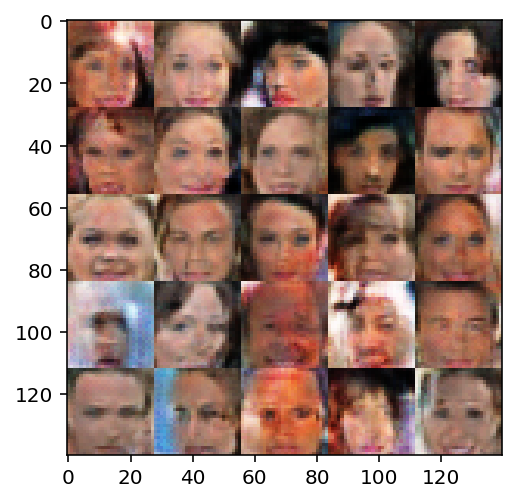

Epoch 1/1|Step 3820| Discriminator Loss: 0.98985| Generator Loss: 1.04034| Discriminator Loss > Generator Loss: False
Epoch 1/1|Step 3840| Discriminator Loss: 1.29165| Generator Loss: 0.77863| Discriminator Loss > Generator Loss: True
Epoch 1/1|Step 3860| Discriminator Loss: 0.96008| Generator Loss: 1.11671| Discriminator Loss > Generator Loss: False
Epoch 1/1|Step 3880| Discriminator Loss: 1.10870| Generator Loss: 0.88515| Discriminator Loss > Generator Loss: True
Epoch 1/1|Step 3900| Discriminator Loss: 0.91334| Generator Loss: 1.13548| Discriminator Loss > Generator Loss: False
Epoch 1/1|Step 3920| Discriminator Loss: 1.19166| Generator Loss: 0.70875| Discriminator Loss > Generator Loss: True
Epoch 1/1|Step 3940| Discriminator Loss: 0.99055| Generator Loss: 0.93922| Discriminator Loss > Generator Loss: True
Epoch 1/1|Step 3960| Discriminator Loss: 1.06426| Generator Loss: 0.95497| Discriminator Loss > Generator Loss: True
Epoch 1/1|Step 3980| Discriminator Loss: 1.07255| Generator L

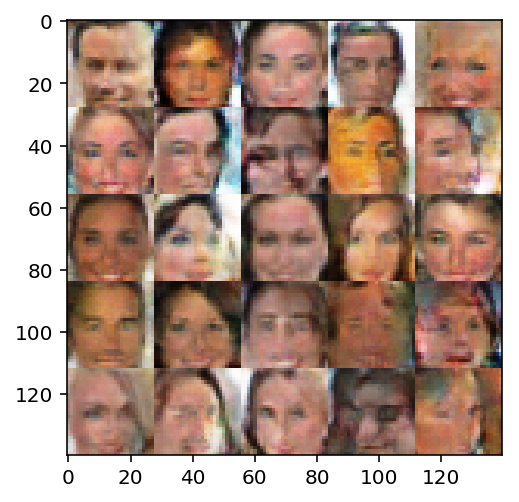

Epoch 1/1|Step 4020| Discriminator Loss: 1.20128| Generator Loss: 0.87821| Discriminator Loss > Generator Loss: True
Epoch 1/1|Step 4040| Discriminator Loss: 1.00743| Generator Loss: 1.03935| Discriminator Loss > Generator Loss: False
Epoch 1/1|Step 4060| Discriminator Loss: 1.15165| Generator Loss: 0.80830| Discriminator Loss > Generator Loss: True
Epoch 1/1|Step 4080| Discriminator Loss: 1.11283| Generator Loss: 1.12311| Discriminator Loss > Generator Loss: False
Epoch 1/1|Step 4100| Discriminator Loss: 0.96621| Generator Loss: 1.02588| Discriminator Loss > Generator Loss: False
Epoch 1/1|Step 4120| Discriminator Loss: 1.12121| Generator Loss: 0.85267| Discriminator Loss > Generator Loss: True
Epoch 1/1|Step 4140| Discriminator Loss: 0.94986| Generator Loss: 1.15939| Discriminator Loss > Generator Loss: False
Epoch 1/1|Step 4160| Discriminator Loss: 0.98404| Generator Loss: 1.18789| Discriminator Loss > Generator Loss: False
Epoch 1/1|Step 4180| Discriminator Loss: 1.36509| Generator

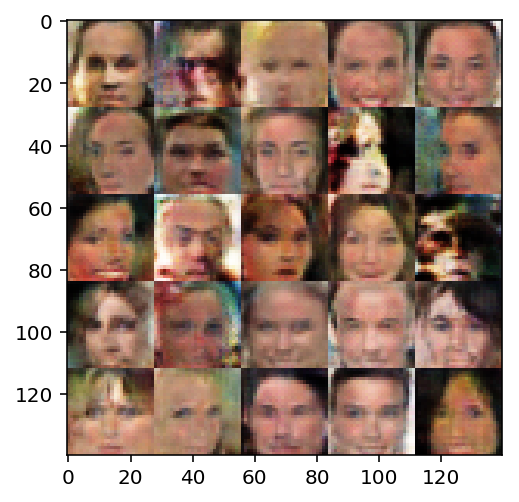

Epoch 1/1|Step 4220| Discriminator Loss: 1.03821| Generator Loss: 0.88006| Discriminator Loss > Generator Loss: True
Epoch 1/1|Step 4240| Discriminator Loss: 1.02443| Generator Loss: 0.85524| Discriminator Loss > Generator Loss: True
Epoch 1/1|Step 4260| Discriminator Loss: 1.01002| Generator Loss: 1.00207| Discriminator Loss > Generator Loss: True
Epoch 1/1|Step 4280| Discriminator Loss: 0.85771| Generator Loss: 1.17403| Discriminator Loss > Generator Loss: False
Epoch 1/1|Step 4300| Discriminator Loss: 1.28596| Generator Loss: 0.65055| Discriminator Loss > Generator Loss: True
Epoch 1/1|Step 4320| Discriminator Loss: 1.01912| Generator Loss: 0.89222| Discriminator Loss > Generator Loss: True
Epoch 1/1|Step 4340| Discriminator Loss: 1.13248| Generator Loss: 0.75186| Discriminator Loss > Generator Loss: True
Epoch 1/1|Step 4360| Discriminator Loss: 1.29267| Generator Loss: 0.62655| Discriminator Loss > Generator Loss: True
Epoch 1/1|Step 4380| Discriminator Loss: 0.97024| Generator Los

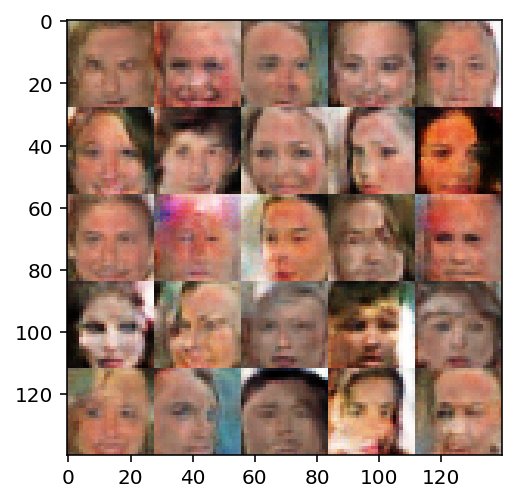

Epoch 1/1|Step 4420| Discriminator Loss: 1.07720| Generator Loss: 0.78057| Discriminator Loss > Generator Loss: True
Epoch 1/1|Step 4440| Discriminator Loss: 0.99021| Generator Loss: 0.88885| Discriminator Loss > Generator Loss: True
Epoch 1/1|Step 4460| Discriminator Loss: 1.18781| Generator Loss: 0.77306| Discriminator Loss > Generator Loss: True
Epoch 1/1|Step 4480| Discriminator Loss: 1.08149| Generator Loss: 0.83799| Discriminator Loss > Generator Loss: True
Epoch 1/1|Step 4500| Discriminator Loss: 1.09986| Generator Loss: 0.88686| Discriminator Loss > Generator Loss: True
Epoch 1/1|Step 4520| Discriminator Loss: 0.96201| Generator Loss: 1.19517| Discriminator Loss > Generator Loss: False
Epoch 1/1|Step 4540| Discriminator Loss: 0.88771| Generator Loss: 1.38046| Discriminator Loss > Generator Loss: False
Epoch 1/1|Step 4560| Discriminator Loss: 1.23889| Generator Loss: 0.68990| Discriminator Loss > Generator Loss: True
Epoch 1/1|Step 4580| Discriminator Loss: 0.93657| Generator Lo

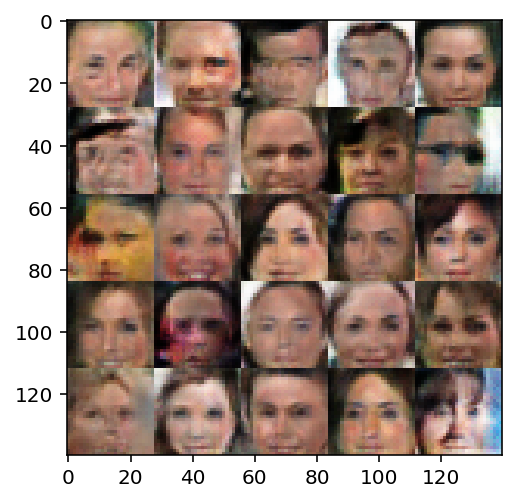

Epoch 1/1|Step 4620| Discriminator Loss: 0.96583| Generator Loss: 1.10094| Discriminator Loss > Generator Loss: False
Epoch 1/1|Step 4640| Discriminator Loss: 1.30192| Generator Loss: 0.65212| Discriminator Loss > Generator Loss: True
Epoch 1/1|Step 4660| Discriminator Loss: 1.00655| Generator Loss: 1.03017| Discriminator Loss > Generator Loss: False
Epoch 1/1|Step 4680| Discriminator Loss: 1.27637| Generator Loss: 0.61152| Discriminator Loss > Generator Loss: True
Epoch 1/1|Step 4700| Discriminator Loss: 0.98473| Generator Loss: 0.97904| Discriminator Loss > Generator Loss: True
Epoch 1/1|Step 4720| Discriminator Loss: 0.94708| Generator Loss: 1.01721| Discriminator Loss > Generator Loss: False
Epoch 1/1|Step 4740| Discriminator Loss: 0.99975| Generator Loss: 0.96334| Discriminator Loss > Generator Loss: True
Epoch 1/1|Step 4760| Discriminator Loss: 1.02186| Generator Loss: 0.92276| Discriminator Loss > Generator Loss: True
Epoch 1/1|Step 4780| Discriminator Loss: 0.90333| Generator L

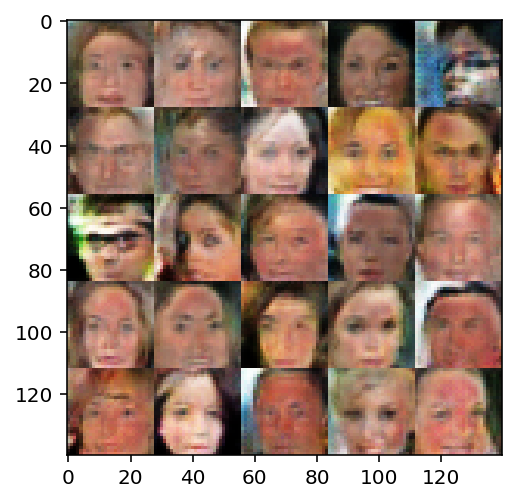

Epoch 1/1|Step 4820| Discriminator Loss: 0.96771| Generator Loss: 1.20331| Discriminator Loss > Generator Loss: False
Epoch 1/1|Step 4840| Discriminator Loss: 1.05780| Generator Loss: 1.39100| Discriminator Loss > Generator Loss: False
Epoch 1/1|Step 4860| Discriminator Loss: 1.38149| Generator Loss: 0.58834| Discriminator Loss > Generator Loss: True
Epoch 1/1|Step 4880| Discriminator Loss: 0.97943| Generator Loss: 1.32349| Discriminator Loss > Generator Loss: False
Epoch 1/1|Step 4900| Discriminator Loss: 1.05778| Generator Loss: 1.19856| Discriminator Loss > Generator Loss: False
Epoch 1/1|Step 4920| Discriminator Loss: 1.10692| Generator Loss: 0.86952| Discriminator Loss > Generator Loss: True
Epoch 1/1|Step 4940| Discriminator Loss: 1.11698| Generator Loss: 0.93904| Discriminator Loss > Generator Loss: True
Epoch 1/1|Step 4960| Discriminator Loss: 0.98908| Generator Loss: 0.91194| Discriminator Loss > Generator Loss: True
Epoch 1/1|Step 4980| Discriminator Loss: 1.04759| Generator 

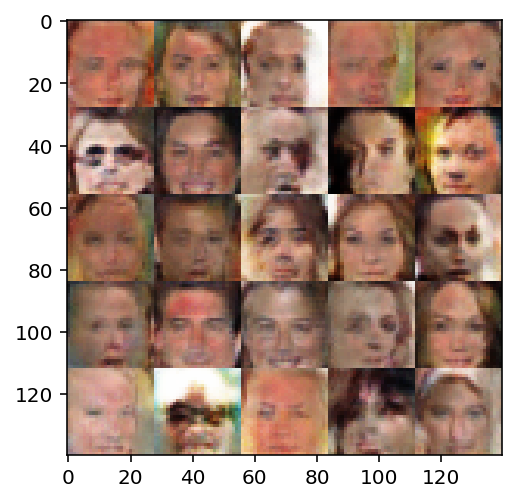

Epoch 1/1|Step 5020| Discriminator Loss: 1.19529| Generator Loss: 0.82473| Discriminator Loss > Generator Loss: True
Epoch 1/1|Step 5040| Discriminator Loss: 1.04427| Generator Loss: 0.86938| Discriminator Loss > Generator Loss: True
Epoch 1/1|Step 5060| Discriminator Loss: 1.22005| Generator Loss: 1.06353| Discriminator Loss > Generator Loss: True
Epoch 1/1|Step 5080| Discriminator Loss: 1.12738| Generator Loss: 0.84069| Discriminator Loss > Generator Loss: True
Epoch 1/1|Step 5100| Discriminator Loss: 1.13986| Generator Loss: 0.98277| Discriminator Loss > Generator Loss: True
Epoch 1/1|Step 5120| Discriminator Loss: 1.11301| Generator Loss: 0.90867| Discriminator Loss > Generator Loss: True
Epoch 1/1|Step 5140| Discriminator Loss: 1.17388| Generator Loss: 0.83826| Discriminator Loss > Generator Loss: True
Epoch 1/1|Step 5160| Discriminator Loss: 1.04423| Generator Loss: 1.26130| Discriminator Loss > Generator Loss: False
Epoch 1/1|Step 5180| Discriminator Loss: 0.99730| Generator Los

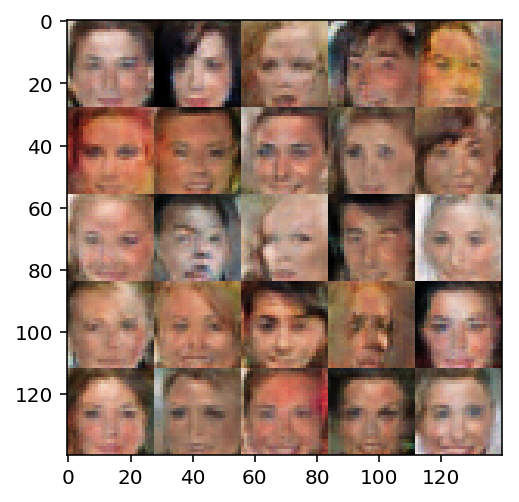

Epoch 1/1|Step 5220| Discriminator Loss: 0.99259| Generator Loss: 1.05935| Discriminator Loss > Generator Loss: False
Epoch 1/1|Step 5240| Discriminator Loss: 1.14219| Generator Loss: 0.71121| Discriminator Loss > Generator Loss: True
Epoch 1/1|Step 5260| Discriminator Loss: 1.03135| Generator Loss: 1.47257| Discriminator Loss > Generator Loss: False
Epoch 1/1|Step 5280| Discriminator Loss: 1.16003| Generator Loss: 0.92721| Discriminator Loss > Generator Loss: True
Epoch 1/1|Step 5300| Discriminator Loss: 1.05343| Generator Loss: 1.07121| Discriminator Loss > Generator Loss: False
Epoch 1/1|Step 5320| Discriminator Loss: 1.00213| Generator Loss: 0.92402| Discriminator Loss > Generator Loss: True
Epoch 1/1|Step 5340| Discriminator Loss: 1.02414| Generator Loss: 1.07894| Discriminator Loss > Generator Loss: False
Epoch 1/1|Step 5360| Discriminator Loss: 1.05128| Generator Loss: 1.01712| Discriminator Loss > Generator Loss: True
Epoch 1/1|Step 5380| Discriminator Loss: 1.15864| Generator 

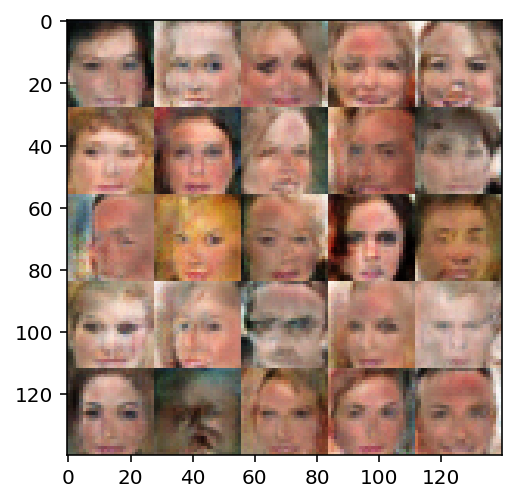

Epoch 1/1|Step 5420| Discriminator Loss: 1.18694| Generator Loss: 0.98535| Discriminator Loss > Generator Loss: True
Epoch 1/1|Step 5440| Discriminator Loss: 1.36866| Generator Loss: 0.71543| Discriminator Loss > Generator Loss: True
Epoch 1/1|Step 5460| Discriminator Loss: 1.18941| Generator Loss: 0.77619| Discriminator Loss > Generator Loss: True
Epoch 1/1|Step 5480| Discriminator Loss: 1.30539| Generator Loss: 0.74494| Discriminator Loss > Generator Loss: True
Epoch 1/1|Step 5500| Discriminator Loss: 0.98502| Generator Loss: 0.96927| Discriminator Loss > Generator Loss: True
Epoch 1/1|Step 5520| Discriminator Loss: 1.09191| Generator Loss: 1.01070| Discriminator Loss > Generator Loss: True
Epoch 1/1|Step 5540| Discriminator Loss: 1.13836| Generator Loss: 1.04841| Discriminator Loss > Generator Loss: True
Epoch 1/1|Step 5560| Discriminator Loss: 1.03712| Generator Loss: 0.92499| Discriminator Loss > Generator Loss: True
Epoch 1/1|Step 5580| Discriminator Loss: 1.05946| Generator Loss

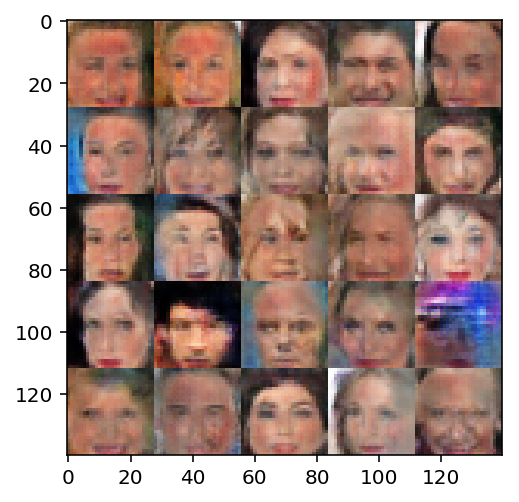

Epoch 1/1|Step 5620| Discriminator Loss: 1.27898| Generator Loss: 0.74823| Discriminator Loss > Generator Loss: True
Epoch 1/1|Step 5640| Discriminator Loss: 0.84305| Generator Loss: 1.35153| Discriminator Loss > Generator Loss: False
Epoch 1/1|Step 5660| Discriminator Loss: 0.95213| Generator Loss: 1.08656| Discriminator Loss > Generator Loss: False
Epoch 1/1|Step 5680| Discriminator Loss: 1.10545| Generator Loss: 0.98424| Discriminator Loss > Generator Loss: True
Epoch 1/1|Step 5700| Discriminator Loss: 0.89102| Generator Loss: 1.28228| Discriminator Loss > Generator Loss: False
Epoch 1/1|Step 5720| Discriminator Loss: 1.00370| Generator Loss: 1.02736| Discriminator Loss > Generator Loss: False
Epoch 1/1|Step 5740| Discriminator Loss: 1.16375| Generator Loss: 0.89239| Discriminator Loss > Generator Loss: True
Epoch 1/1|Step 5760| Discriminator Loss: 1.22734| Generator Loss: 0.72795| Discriminator Loss > Generator Loss: True
Epoch 1/1|Step 5780| Discriminator Loss: 1.03020| Generator 

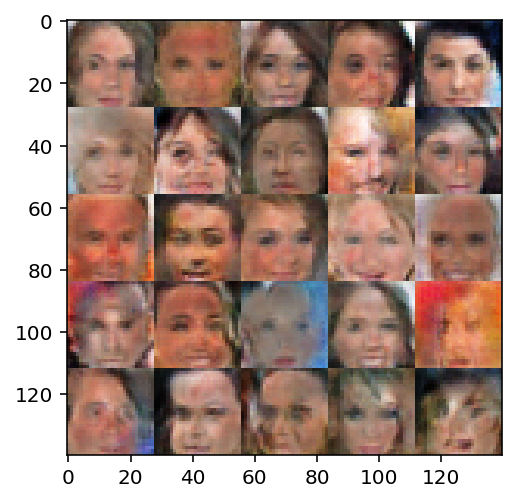

Epoch 1/1|Step 5820| Discriminator Loss: 1.17655| Generator Loss: 0.85388| Discriminator Loss > Generator Loss: True
Epoch 1/1|Step 5840| Discriminator Loss: 1.10408| Generator Loss: 0.91752| Discriminator Loss > Generator Loss: True
Epoch 1/1|Step 5860| Discriminator Loss: 1.09110| Generator Loss: 0.98884| Discriminator Loss > Generator Loss: True
Epoch 1/1|Step 5880| Discriminator Loss: 1.12491| Generator Loss: 0.76205| Discriminator Loss > Generator Loss: True
Epoch 1/1|Step 5900| Discriminator Loss: 1.03452| Generator Loss: 0.88536| Discriminator Loss > Generator Loss: True
Epoch 1/1|Step 5920| Discriminator Loss: 1.13949| Generator Loss: 0.77159| Discriminator Loss > Generator Loss: True
Epoch 1/1|Step 5940| Discriminator Loss: 0.95319| Generator Loss: 0.97146| Discriminator Loss > Generator Loss: False
Epoch 1/1|Step 5960| Discriminator Loss: 1.16711| Generator Loss: 0.78440| Discriminator Loss > Generator Loss: True
Epoch 1/1|Step 5980| Discriminator Loss: 1.22548| Generator Los

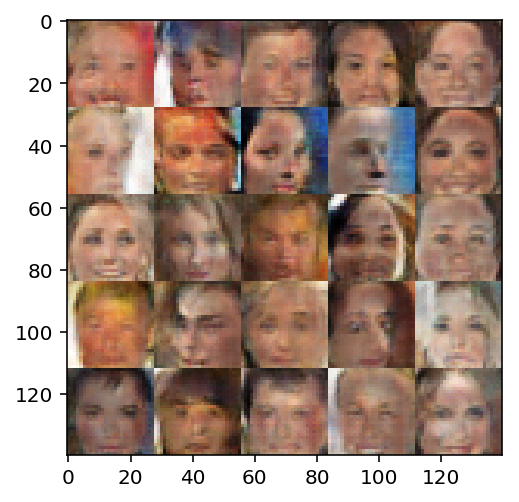

Epoch 1/1|Step 6020| Discriminator Loss: 1.04562| Generator Loss: 0.93951| Discriminator Loss > Generator Loss: True
Epoch 1/1|Step 6040| Discriminator Loss: 1.17808| Generator Loss: 0.87053| Discriminator Loss > Generator Loss: True
Epoch 1/1|Step 6060| Discriminator Loss: 1.10341| Generator Loss: 0.80169| Discriminator Loss > Generator Loss: True
Epoch 1/1|Step 6080| Discriminator Loss: 1.28054| Generator Loss: 0.69961| Discriminator Loss > Generator Loss: True
Epoch 1/1|Step 6100| Discriminator Loss: 0.91838| Generator Loss: 1.36216| Discriminator Loss > Generator Loss: False
Epoch 1/1|Step 6120| Discriminator Loss: 1.05882| Generator Loss: 0.83781| Discriminator Loss > Generator Loss: True
Epoch 1/1|Step 6140| Discriminator Loss: 1.13545| Generator Loss: 0.78992| Discriminator Loss > Generator Loss: True
Epoch 1/1|Step 6160| Discriminator Loss: 1.08559| Generator Loss: 0.86171| Discriminator Loss > Generator Loss: True
Epoch 1/1|Step 6180| Discriminator Loss: 1.06795| Generator Los

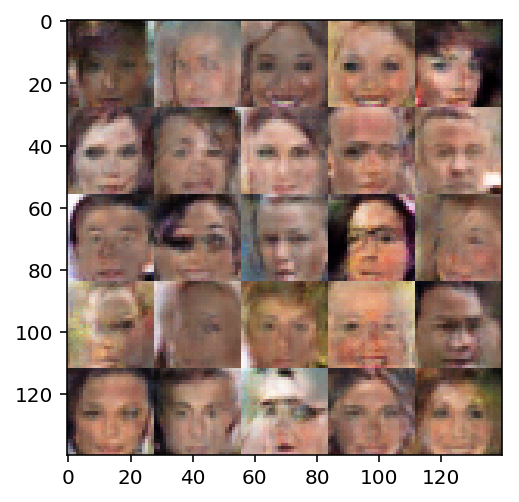

Epoch 1/1|Step 6220| Discriminator Loss: 1.13257| Generator Loss: 0.76651| Discriminator Loss > Generator Loss: True
Epoch 1/1|Step 6240| Discriminator Loss: 1.02858| Generator Loss: 0.90001| Discriminator Loss > Generator Loss: True
Epoch 1/1|Step 6260| Discriminator Loss: 0.98069| Generator Loss: 1.06094| Discriminator Loss > Generator Loss: False
Epoch 1/1|Step 6280| Discriminator Loss: 0.86130| Generator Loss: 1.27900| Discriminator Loss > Generator Loss: False
Epoch 1/1|Step 6300| Discriminator Loss: 1.19703| Generator Loss: 0.73519| Discriminator Loss > Generator Loss: True
Epoch 1/1|Step 6320| Discriminator Loss: 1.17521| Generator Loss: 0.74084| Discriminator Loss > Generator Loss: True


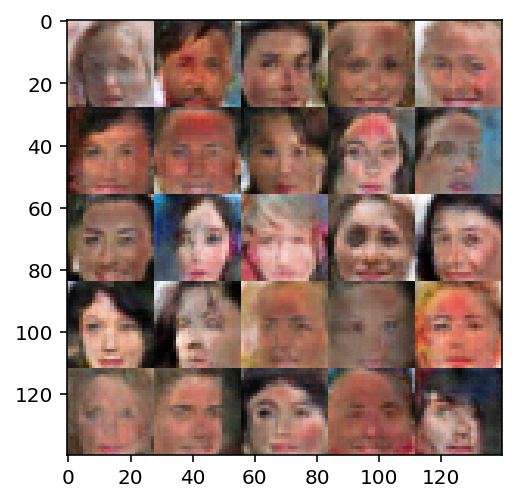

In [68]:
hide_code
batch_size = 32
# z_dim = 128
# learning_rate = 0.0001
# beta1 = 0.5

"""DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE"""
epochs = 1

celeba_dataset = Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, 
          celeba_dataset.get_batches, celeba_dataset.shape, celeba_dataset.image_mode, 20, 200)

## Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.